<div
  style="
    display: flex;
    justify-content: center;
    flex-direction: column;
    align-items: center;
  "
>
<div style="width: 500px; padding: 20px; background: #fff; border: 1px solid #999; color: black; border-radius: 6px">
  <p style="opacity: 0.5; margin-bottom: -10px"><i>TDT4173 Machine Learning 2023</i></p>
  <h1 style="margin-bottom: -5px"><b>Short Notebook 2</b></h1>
  <h3>Kaggle Name: NeuralNet Ninjas™️</h3>
  <br />
  <h3>Team Members:</h3>
  <table style="margin: 0 auto; width: 100%; text-align: left">
    <tr style="background: #eee">
      <th style="border: 0.5px solid #999; color: black">Name</th>
      <th style="border: 0.5px solid #999; color: black">Student ID</th>
    </tr>
    <tr style="background: #fff">
      <td style="border-width: 0.5px; border-color: #555">Eggen, Sivert Antonsen</td>
      <td style="border-width: 0.5px; border-color: #555">54 46 17</td>
    </tr>
    <tr>
      <td style="border-width: 0.5px; border-color: #555">Grude, Kristoffer VI Nicolay Broch</td>
      <td style="border-width: 0.5px; border-color: #555">52 77 63</td>
    </tr>
    <tr>
      <td style="border-width: 0.5px; border-color: #555">Raa, Mathias Skogen</td>
      <td style="border-width: 0.5px; border-color: #555">54 46 38</td>
    </tr>
  </table>
  <br />
  <h3>Runtime: x hours</h3>
  <p style="opacity: 0.5;"><i>Specs: MacBook Pro 2021, Apple M1 Pro Chip, 16 GB RAM</i></p>
  </div>
</div>


---

In [96]:
# Seed Control
import random, torch, numpy as np

def random_ctl(use_seed=0):
    seed = use_seed if use_seed else random.randint(1,1000000)
    print(f"Using seed: {seed}")

    # python RNG
    random.seed(seed)

    # pytorch RNGs
    torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    if use_seed:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark     = False

    # numpy RNG
    np.random.seed(seed)

    return seed

random_ctl(1111)

Using seed: 1111


1111

In [97]:
# Utils
import os

# Data
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_predict, KFold, train_test_split

# Models
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common import space

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import scipy.optimize as opt

import fastai
import fastai.tabular as tabular
import fastai.tabular.all as tabular_all

#######################################
# Ray version 2.6.3 must be installed
# in order to train Autogluon within 
# the time limit.
#######################################

# 1 - Preprocessing

### 1.1 - Dataset loading

In [98]:
# Load data

y_data = {}
y_test_data = pd.read_csv(f"../data/test.csv")
X_test_estimated_data = {}
X_train_estimated_data = {}
X_train_observed_data = {}
locations = ["A", "B", "C"]

for location in locations:
    y_data[location] = pd.read_parquet(f"../data/{location}/train_targets.parquet")

    X_test_estimated_data[location] = pd.read_parquet(
        f"../data/{location}/X_test_estimated.parquet"
    )
    X_train_estimated_data[location] = pd.read_parquet(
        f"../data/{location}/X_train_estimated.parquet"
    )
    X_train_observed_data[location] = pd.read_parquet(
        f"../data/{location}/X_train_observed.parquet"
    )

In [99]:
# Combine data

combine_data = (
    lambda data: pd.concat(data.values(), keys=data.keys())
    .reset_index()
    .drop(columns="level_1")
    .rename(columns={"level_0": "location"})
)

y = combine_data(y_data).sort_values(by=["time", "location"])

y_test_data = y_test_data.rename(columns={"prediction": "pv_measurement"})
y_test_data = y_test_data[["time", "location", "pv_measurement"]]

# Add Kaggle test data to y
y = pd.concat([y, y_test_data]).sort_values(by=["time", "location"])
y["time"] = pd.to_datetime(y["time"])

X_train_observed = combine_data(X_train_observed_data).assign(data_type="observed")
X_train_estimated = combine_data(X_train_estimated_data).assign(data_type="estimated")
X_test_estimated = combine_data(X_test_estimated_data).assign(data_type="test")

X = pd.concat([X_train_observed, X_train_estimated, X_test_estimated]).sort_values(
    by=["date_forecast", "location"]
)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (413791, 49)
y shape: (101248, 3)


### 1.2 - Data cleaning

#### 1.2.1 - Resample data to hourly granularity

In [100]:
# Custom aggregation function
def custom_resample(aggregation_dict, default_agg = "mean"): 
    result = {}
    for column in X.columns:
        if column in ["date_forecast"]:
            continue

        aggregation = aggregation_dict.get(column, default_agg)  # Use 'mean' by default

        result[column] = aggregation
    return result

# Specify the aggregation method for specific columns
aggregation_dict = {
    "location": "first",
    "data_type": "first",

    # Categorical weather features
    "is_day:idx": "first",
    "is_in_shadow:idx": "first",
    "precip_type_5min:idx": "first",
    "dew_or_rime:idx": "first",
    "snow_drift:idx": "first",
}

X = (
    X.set_index("date_forecast")
    .groupby("location")
    .resample("H")
    .apply(custom_resample(aggregation_dict))
    .drop(columns=["location"])
    .reset_index()
    .sort_values(by=["date_forecast", "location"])
    .reset_index(drop=True)
)

X_no_resample = (
    X.set_index("date_forecast")
    .groupby("location")
    .resample("H")
    .apply(custom_resample(aggregation_dict, "first"))
    .drop(columns=["location"])
    .reset_index()
    .sort_values(by=["date_forecast", "location"])
    .reset_index(drop=True)
)


#### 1.2.2 - Remove NaN rows

In [101]:
# Find all rows that only contain NaN in X

nan_rows = X[X.drop(columns=["date_forecast", "location"]).isna().all(axis=1)].index

X = X.drop(nan_rows).reset_index(drop=True)
display(X.describe())

# No-resample version
nan_rows = X_no_resample[X_no_resample.drop(columns=["date_forecast", "location"]).isna().all(axis=1)].index

X_no_resample = X_no_resample.drop(nan_rows).reset_index(drop=True)

# Find all rows that only contain NaN in y

nan_rows = y[y.drop(columns=["time", "location"]).isna().all(axis=1)].index

y = y.drop(nan_rows).reset_index(drop=True)
display(y.describe())


date_forecast  absolute_humidity_2m:gm3  \
count                      103450             103450.000000   
mean   2021-02-27 11:19:43.458675                  6.022451   
min           2019-01-01 00:00:00                  0.500000   
25%           2020-02-15 04:00:00                  4.000000   
50%           2021-02-08 08:30:00                  5.450000   
75%           2022-02-02 13:00:00                  7.900000   
max           2023-07-03 23:00:00                 18.700001   
std                           NaN                  2.766933   

       air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
count        103450.000000          85710.000000           1.034500e+05   
mean              1.255468           2818.218750           5.340856e+05   
min               1.139250             27.600000           0.000000e+00   
25%               1.230000           1063.206177           0.000000e+00   
50%               1.255000           1847.675049           1.444562e+04   
75%               1.279000           3831.431152           8.463045e+05   
max               1.441000          12294.901367           2.990596e+06   
std               0.037343           2490.036865           8.363739e+05   

       clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  \
count    103450.000000      95988.000000    103450.000000   103450.000000   
mean        148.357071       1728.615723         0.002707      275.193604   
min           0.000000         27.299997        -1.000000      247.425003   
25%           0.000000        602.687500         0.000000      270.600006   
50%           2.350000       1170.074951         0.000000      275.000000   
75%         233.250000       2085.399902         0.000000      280.649994   
max         835.650024      11673.724609         1.000000      294.924988   
std         232.910690       1777.656860         0.254857        7.007361   

       diffuse_rad:W  ...  sun_elevation:d  super_cooled_liquid_water:kgm2  \
count  103450.000000  ...    103450.000000                   103450.000000   
mean       40.692169  ...        -0.686007                        0.056825   
min         0.000000  ...       -49.931999                        0.000000   
25%         0.000000  ...       -17.985250                        0.000000   
50%         1.400000  ...        -0.422625                        0.000000   
75%        68.193748  ...        16.086188                        0.100000   
max       334.750000  ...        49.943748                        1.375000   
std        61.679428  ...        24.151178                        0.105950   

         t_1000hPa:K  total_cloud_cover:p   visibility:m  wind_speed_10m:ms  \
count  103450.000000        103450.000000  103450.000000      103450.000000   
mean      279.437866            73.615753   33047.601562           3.017211   
min       258.024994             0.000000     132.375000           0.025000   
25%       274.799988            52.900002   17214.430664           1.675000   
50%       278.700012            93.025002   36858.449219           2.675000   
75%       284.093758            99.925003   48121.931641           4.025000   
max       303.250000           100.000000   75489.328125          13.275000   
std         6.689478            34.071289   17768.177734           1.743098   

       wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  \
count        103450.000000        103450.000000            103450.000000   
mean              0.677701             0.670877                 0.000048   
min              -7.225000            -8.400000                -0.100000   
25%              -1.325000            -0.600000                 0.000000   
50%               0.325000             0.700000                 0.000000   
75%               2.500000             1.850000                 0.000000   
max              11.200000             8.825000                 0.100000   
std               2.773586             1.871724            

time  pv_measurement
count                          95184    95184.000000
mean   2021-03-24 10:51:46.807866880      280.506347
min              2018-12-31 23:00:00       -0.000000
25%              2020-04-08 15:45:00        0.000000
50%              2021-03-05 05:30:00        0.000000
75%              2022-01-29 20:00:00      161.287500
max              2023-07-03 23:00:00     5733.420000
std                              NaN      758.866540

#### 1.2.3 - Remove outliers

In [102]:
# Remove repeated values

def find_repeated_indexes(df, column_name, repeat_count=12, ignore_zeros=True) -> list:
    """
    Find and return the indexes of rows with a specified number of repeated values in a given column.

    Parameters:
    - df: DataFrame to search for repeated rows.
    - column_name: Name of the column to check for repeated values.
    - repeat_count: Number of repeated values required to consider a row as a match.

    Returns:
    - List of indexes for rows with the specified number of repeated values in the given column.
    """
    repeated_indexes = []
    temp_repeated_indexes = []
    current_value = None

    for index, row in df.iterrows():
        value = row[column_name]

        if value == 0 and ignore_zeros:
            continue

        if value == current_value:
            temp_repeated_indexes.append(index)
        else:
            current_value = value
            if len(temp_repeated_indexes) <= repeat_count:
                temp_repeated_indexes.clear()
            else:
                repeated_indexes.extend(
                    set(temp_repeated_indexes) - set(repeated_indexes)
                )
                temp_repeated_indexes.clear()

    return repeated_indexes

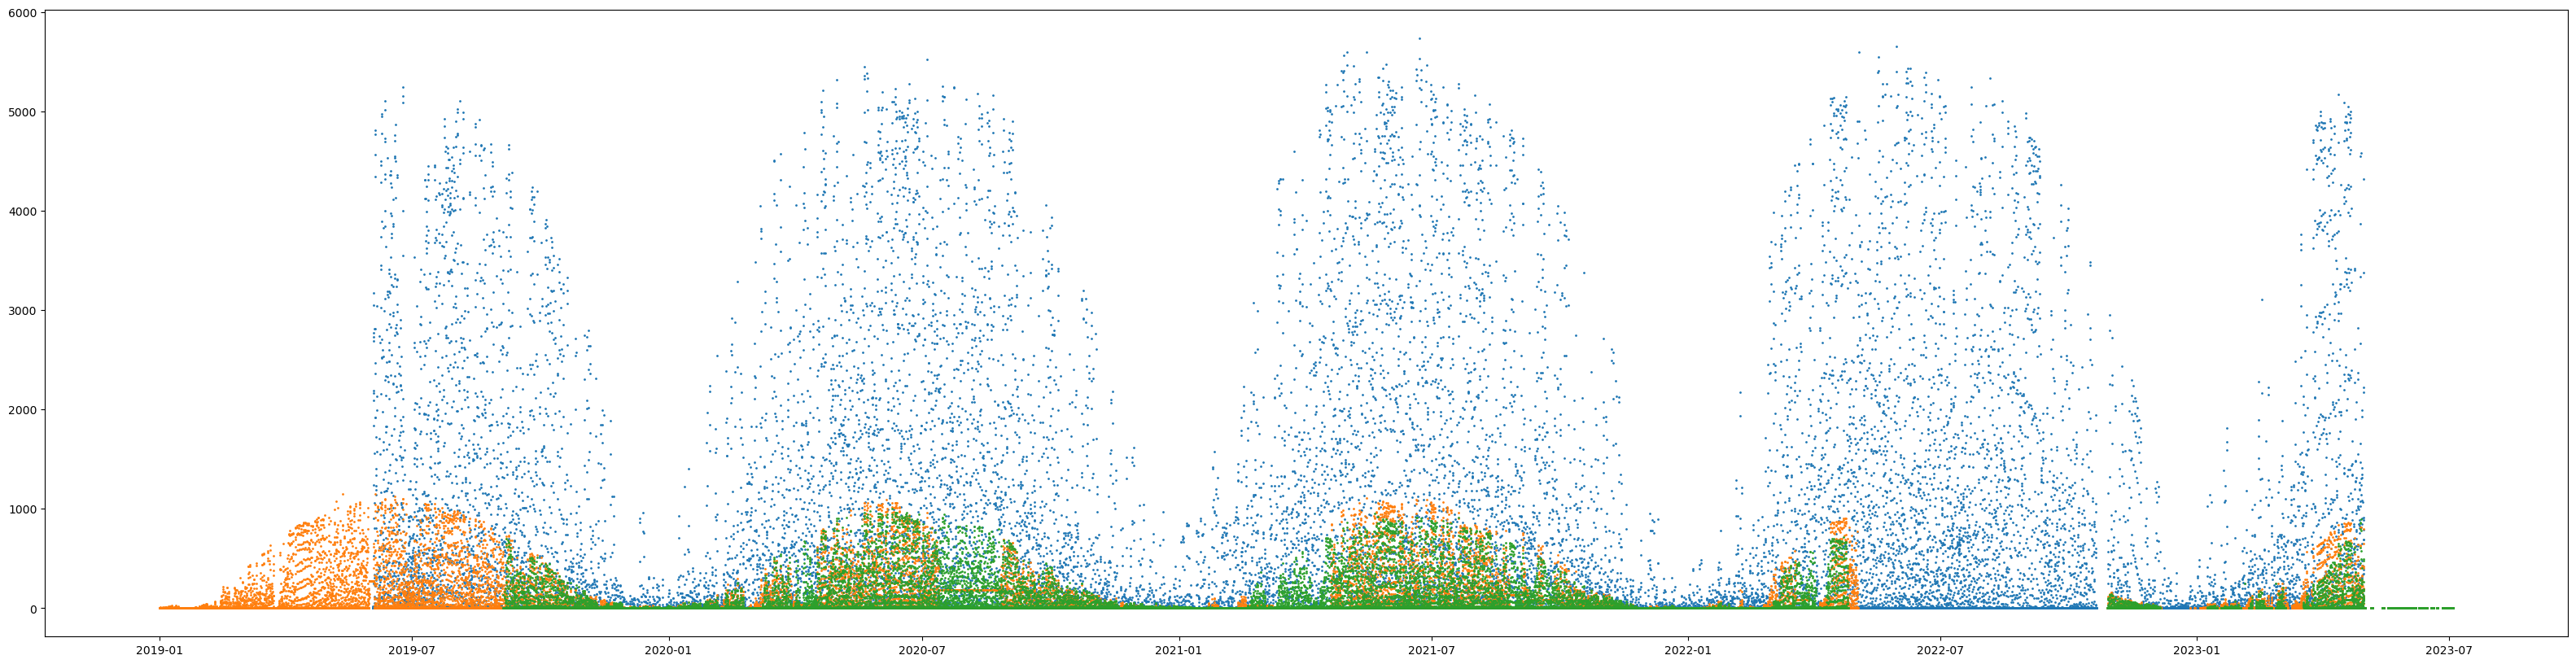

In [103]:
# Visulize data per location
plt.figure(figsize=(40, 10))

for location in locations:
    plt.scatter(y[y.location == location].time, y[y.location == location]["pv_measurement"], s=1)

### 1.3 - Combine X and y

#### 1.3.1 Create no-resample preprocessing data

In [104]:
# Remove repeated values (Version 1)

# Create a copy of X and y
y_no_resample = y.copy()

for location in locations:
    # Drop rows with repeated values over 24 hours
    repeated_indexes = find_repeated_indexes(
        y_no_resample[y_no_resample.location == location].sort_values(by=["location", "time"]),
        "pv_measurement",
        repeat_count=24,
        ignore_zeros=True,
    )

    y_no_resample = y_no_resample.drop(repeated_indexes).reset_index(drop=True)

    # Drop rows with repeated zeros over 4 days,
    # ignore dates after '2023-05-01 00:00:00' as they are test data

    repeated_indexes = find_repeated_indexes(
        y_no_resample[(y_no_resample.location == location) & (y_no_resample.time <= "2023-05-01 00:00:00")].sort_values(
            by=["location", "time"]
        ),
        "pv_measurement",
        repeat_count=72,
        ignore_zeros=False,
    )

    y_no_resample = y_no_resample.drop(repeated_indexes).reset_index(drop=True)

In [105]:
# Combine X and y on date_forecast and location. Drop rows where a row does not exist in both X and y.

data_no_resample = pd.merge(
    X_no_resample, y_no_resample, left_on=["date_forecast", "location"], right_on=["time", "location"]
).drop(columns=["time"])

#### 1.3.1 Create standard preprocessing data

In [106]:
# Remove repeated values (Version 1)

# Create a copy of X and y
X_standard = X.copy()
y_standard = y.copy()

for location in locations:
    # Drop rows with repeated values over 24 hours
    repeated_indexes = find_repeated_indexes(
        y_standard[y_standard.location == location].sort_values(by=["location", "time"]),
        "pv_measurement",
        repeat_count=24,
        ignore_zeros=True,
    )

    y_standard = y_standard.drop(repeated_indexes).reset_index(drop=True)

    # Drop rows with repeated zeros over 4 days,
    # ignore dates after '2023-05-01 00:00:00' as they are test data

    repeated_indexes = find_repeated_indexes(
        y_standard[(y_standard.location == location) & (y_standard.time <= "2023-05-01 00:00:00")].sort_values(
            by=["location", "time"]
        ),
        "pv_measurement",
        repeat_count=72,
        ignore_zeros=False,
    )

    y_standard = y_standard.drop(repeated_indexes).reset_index(drop=True)

In [107]:
# Combine X and y on date_forecast and location. Drop rows where a row does not exist in both X and y.

data_standard = pd.merge(
    X_standard, y_standard, left_on=["date_forecast", "location"], right_on=["time", "location"]
).drop(columns=["time"])

#### 1.3.2 Create simple preprocessing data 

In [108]:
# Remove repeated values (Version 2)

# Create a copy of X and y
X_simple = X.copy()
y_simple = y.copy()

for location in locations:
    # Drop rows with repeated values over 24 hours
    repeated_indexes = find_repeated_indexes(
        y_simple[y_simple.location == location].sort_values(by=["location", "time"]),
        "pv_measurement",
        repeat_count=48,
        ignore_zeros=True,
    )

    y_simple = y_simple.drop(repeated_indexes).reset_index(drop=True)

In [109]:
# Combine X and y on date_forecast and location. Drop rows where a row does not exist in both X and y.

data_simple = pd.merge(
    X_simple, y_simple, left_on=["date_forecast", "location"], right_on=["time", "location"]
).drop(columns=["time"])

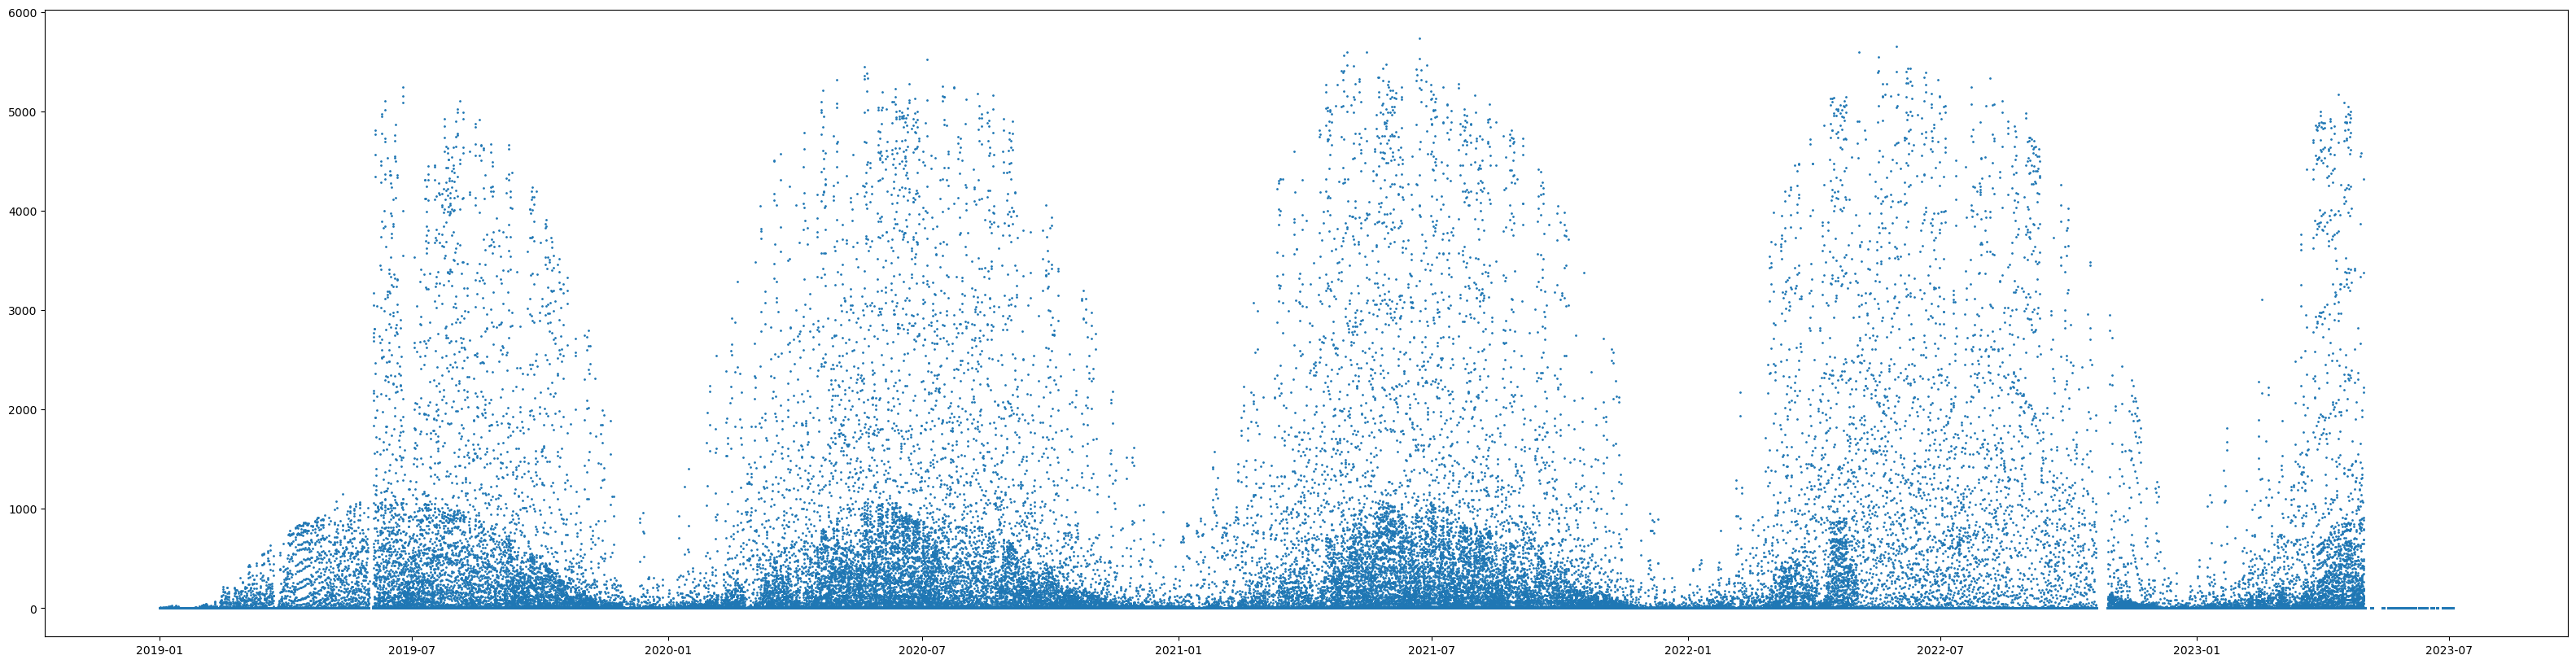

In [110]:
plt.figure(figsize=(40, 10))
plt.scatter(data_simple.date_forecast, data_simple["pv_measurement"], s=1)

### 1.4 - Feature Engineering

#### 1.4.1 - Add sinus and cosinus features

In [111]:
# Function that sinus and cosinus transform a column

def add_sin_cos(df, column_name, period):
    """
    Add sinus and cosinus transformed columns for the given column.

    Parameters:
    - df: DataFrame to add the transformed columns to.
    - column_name: Name of the column to transform.
    - period: Period of the sinus and cosinus functions.
    """
    df[f"{column_name}_sin"] = np.sin(2 * np.pi * df[column_name] / period)
    df[f"{column_name}_cos"] = np.cos(2 * np.pi * df[column_name] / period)


In [112]:
# Add sinus and cosinus transformed columns for time for data_standard

data_standard["hour"] = data_standard["date_forecast"].dt.hour
data_standard["month"] = data_standard["date_forecast"].dt.month

add_sin_cos(data_standard, "hour", 23)
add_sin_cos(data_standard, "month", 12)

In [113]:
# Add sinus and cosinus transformed columns for time for data_simple

data_simple["hour"] = data_simple["date_forecast"].dt.hour
data_simple["month"] = data_simple["date_forecast"].dt.month

add_sin_cos(data_simple, "hour", 23)
add_sin_cos(data_simple, "month", 12)

In [114]:
# Add sinus and cosinus transformed columns for time for data_no_resample

data_no_resample["hour"] = data_no_resample["date_forecast"].dt.hour
data_no_resample["month"] = data_no_resample["date_forecast"].dt.month

add_sin_cos(data_no_resample, "hour", 23)
add_sin_cos(data_no_resample, "month", 12)

#### 1.4.2 - Transform sun_azimuth feature

In [115]:
# Sun azimuth feature engineering

def convert_from_degree_to_ciruclar(df, feature):
    """
    Converts a feature from degree to circular
    """
    df[feature + "_sin"] = np.sin(np.radians(df[feature]))
    df[feature + "_cos"] = np.cos(np.radians(df[feature]))

    return df

In [116]:
# Convert sun_azimuth from degree to circular for data_standard
data_standard = convert_from_degree_to_ciruclar(data_standard, "sun_azimuth:d")

In [117]:
# Convert sun_azimuth from degree to circular for data_standard
data_simple = convert_from_degree_to_ciruclar(data_simple, "sun_azimuth:d")

In [118]:
# Convert sun_azimuth from degree to circular for data_standard
data_no_resample = convert_from_degree_to_ciruclar(data_no_resample, "sun_azimuth:d")

### 1.5 - Result

In [119]:
data_standard.describe().T.drop(columns=["std", "25%", "50%", "75%"])

count                        mean  \
date_forecast                     85205  2021-03-27 13:59:56.155155   
absolute_humidity_2m:gm3        85205.0                    6.214849   
air_density_2m:kgm3             85205.0                    1.252912   
ceiling_height_agl:m            69963.0                 2903.989258   
clear_sky_energy_1h:J           85205.0                  553656.875   
clear_sky_rad:W                 85205.0                  153.780457   
cloud_base_agl:m                78892.0                 1748.616577   
dew_or_rime:idx                 85205.0                    0.015879   
dew_point_2m:K                  85205.0                  275.824036   
diffuse_rad:W                   85205.0                   41.908321   
diffuse_rad_1h:J                85205.0                150879.96875   
direct_rad:W                    85205.0                   54.301579   
direct_rad_1h:J                 85205.0                195499.15625   
effective_cloud_cover:p         85205.0                   66.873695   
elevation:m                     85205.0                   11.100123   
fresh_snow_12h:cm               85205.0                    0.092189   
fresh_snow_1h:cm                85205.0                     0.00765   
fresh_snow_24h:cm               85205.0                    0.182312   
fresh_snow_3h:cm                85205.0                    0.022987   
fresh_snow_6h:cm                85205.0                    0.046025   
is_day:idx                      85205.0                     0.50233   
is_in_shadow:idx                85205.0                    0.545203   
msl_pressure:hPa                85205.0                 1009.967468   
precip_5min:mm                  85205.0                    0.005691   
precip_type_5min:idx            85205.0                    0.076944   
pressure_100m:hPa               85205.0                  996.340759   
pressure_50m:hPa                85205.0                 1002.460632   
prob_rime:p                     85205.0                    0.591769   
rain_water:kgm2                 85205.0                    0.009961   
relative_humidity_1000hPa:p     85205.0                   73.533554   
sfc_pressure:hPa                85205.0                 1008.607544   
snow_density:kgm3                2512.0                       250.0   
snow_depth:cm                   85205.0                    0.114916   
snow_drift:idx                  85205.0                    0.000023   
snow_melt_10min:mm              85205.0                    0.000208   
snow_water:kgm2                 85205.0                    0.088535   
sun_azimuth:d                   85205.0                  179.642044   
sun_elevation:d                 85205.0                    0.068016   
super_cooled_liquid_water:kgm2  85205.0                    0.057439   
t_1000hPa:K                     85205.0                  279.956207   
total_cloud_cover:p             85205.0                   73.569359   
visibility:m                    85205.0                32871.074219   
wind_speed_10m:ms               85205.0                    3.026494   
wind_speed_u_10m:ms             85205.0                    0.676903   
wind_speed_v_10m:ms             85205.0                    0.620215   
wind_speed_w_1000hPa:ms         85205.0                    0.000042   
date_calc                         13085  2023-02-20 17:57:39.905999   
pv_measurement                  85205.0                  308.626345   
hour                            85205.0                    11.50274   
month                           85205.0                    6.404307   
hour_sin                        85205.0                   -0.000119   
hour_cos                        85205.0                        0.04   
month_sin                       85205.0                    0.031021   
month_cos                       85205.0                     0.00923   
sun_azimuth:d_sin               85205.0                    0.012768   
sun_azimuth:d_cos               85205.0                   

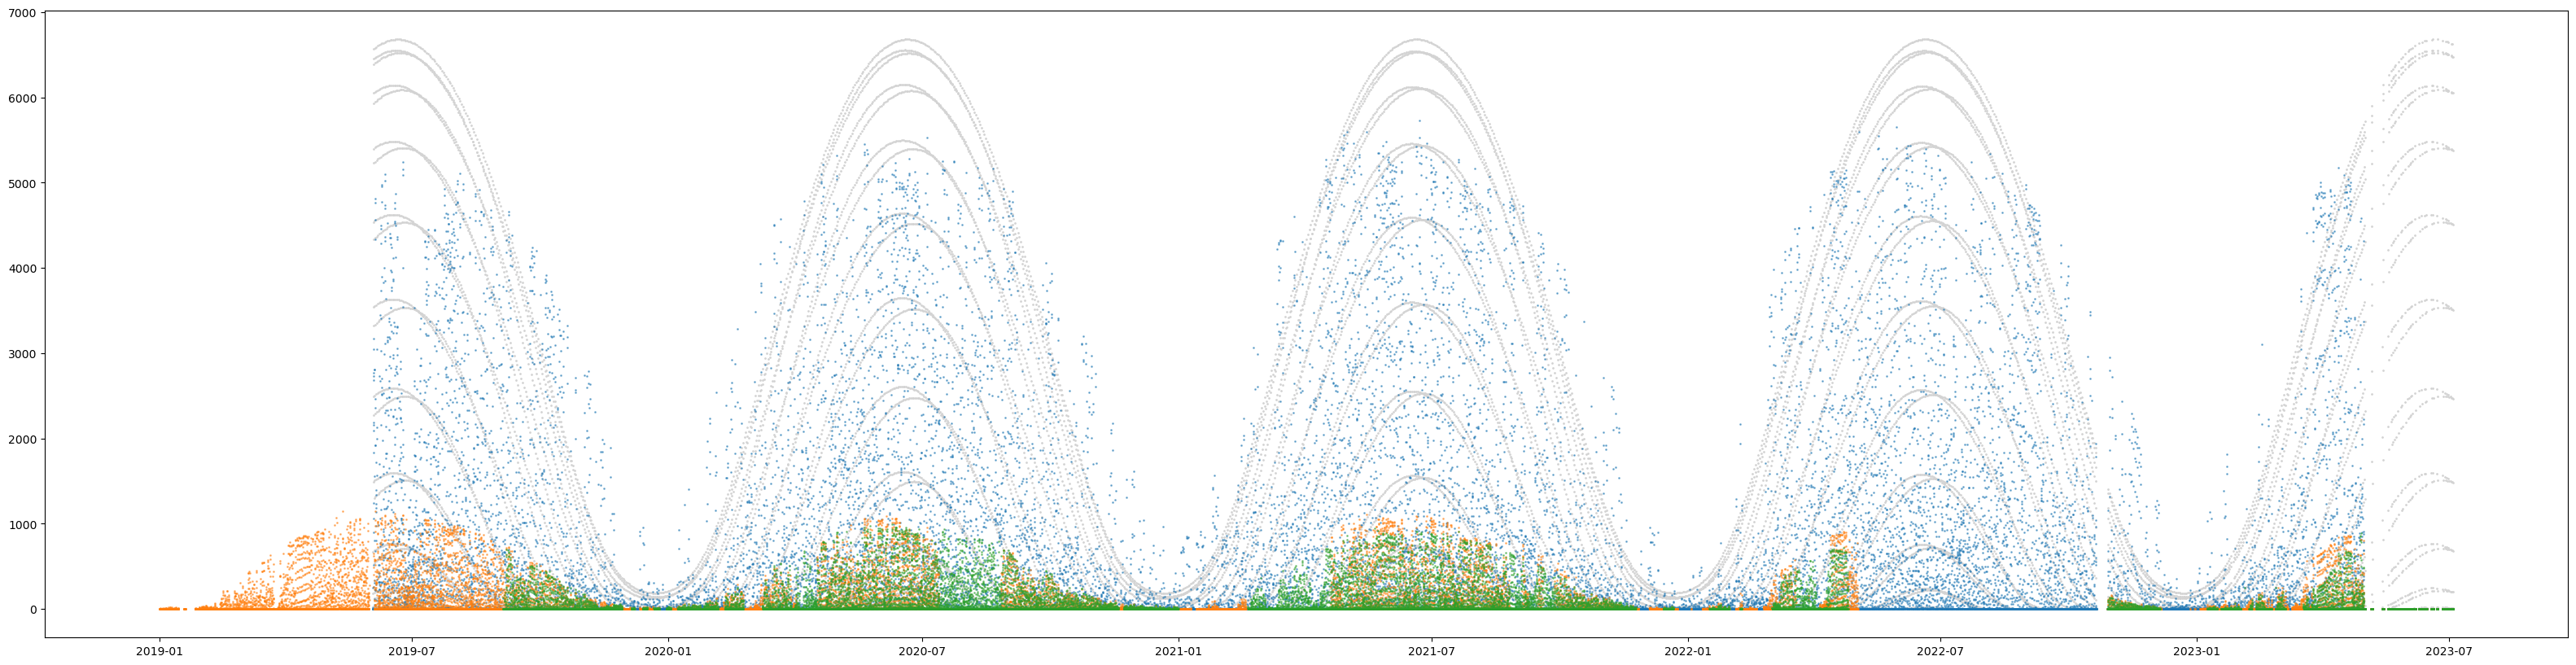

In [120]:
# Plot alignment and values
plt.figure(figsize=(40, 10))

plt.scatter(
    data_standard[data_standard.location == "A"].date_forecast,
    data_standard[data_standard.location == "A"]["clear_sky_rad:W"] * 8,
    s=1,
    color="lightgrey",
)

for loc in locations:
    plt.scatter(
        data_standard[data_standard.location == loc].date_forecast,
        data_standard[data_standard.location == loc]["pv_measurement"],
        s=1,
        alpha=0.5,
    )

In [121]:
data_simple.describe().T.drop(columns=["std", "25%", "50%", "75%"])

count                        mean  \
date_forecast                     92117  2021-03-26 19:47:34.417751   
absolute_humidity_2m:gm3        92117.0                     6.00584   
air_density_2m:kgm3             92117.0                    1.255348   
ceiling_height_agl:m            75668.0                 2880.849121   
clear_sky_energy_1h:J           92117.0                523999.90625   
clear_sky_rad:W                 92117.0                  145.547226   
cloud_base_agl:m                85300.0                 1740.147217   
dew_or_rime:idx                 92117.0                    0.007447   
dew_point_2m:K                  92117.0                  275.219177   
diffuse_rad:W                   92117.0                    39.95409   
diffuse_rad_1h:J                92117.0                  143842.375   
direct_rad:W                    92117.0                   51.247185   
direct_rad_1h:J                 92117.0                 184493.9375   
effective_cloud_cover:p         92117.0                   66.931633   
elevation:m                     92117.0                   11.566648   
fresh_snow_12h:cm               92117.0                    0.118093   
fresh_snow_1h:cm                92117.0                    0.009816   
fresh_snow_24h:cm               92117.0                    0.233314   
fresh_snow_3h:cm                92117.0                    0.029502   
fresh_snow_6h:cm                92117.0                    0.059037   
is_day:idx                      92117.0                    0.486664   
is_in_shadow:idx                92117.0                    0.562567   
msl_pressure:hPa                92117.0                  1009.52356   
precip_5min:mm                  92117.0                    0.005672   
precip_type_5min:idx            92117.0                    0.083882   
pressure_100m:hPa               92117.0                  995.811951   
pressure_50m:hPa                92117.0                 1001.942383   
prob_rime:p                     92117.0                    0.752863   
rain_water:kgm2                 92117.0                    0.009387   
relative_humidity_1000hPa:p     92117.0                   73.522812   
sfc_pressure:hPa                92117.0                 1008.100159   
snow_density:kgm3                4206.0                       250.0   
snow_depth:cm                   92117.0                    0.194885   
snow_drift:idx                  92117.0                    0.000022   
snow_melt_10min:mm              92117.0                    0.000276   
snow_water:kgm2                 92117.0                    0.089012   
sun_azimuth:d                   92117.0                  179.651199   
sun_elevation:d                 92117.0                   -0.999806   
super_cooled_liquid_water:kgm2  92117.0                    0.056464   
t_1000hPa:K                     92117.0                   279.44281   
total_cloud_cover:p             92117.0                   73.510788   
visibility:m                    92117.0                33197.234375   
wind_speed_10m:ms               92117.0                    3.031902   
wind_speed_u_10m:ms             92117.0                     0.65842   
wind_speed_v_10m:ms             92117.0                    0.680368   
wind_speed_w_1000hPa:ms         92117.0                         0.0   
date_calc                         13085  2023-02-20 17:57:39.905999   
pv_measurement                  92117.0                   285.60086   
hour                            92117.0                   11.503349   
month                           92117.0                    6.284638   
hour_sin                        92117.0                   -0.000222   
hour_cos                        92117.0                    0.041075   
month_sin                       92117.0                    0.065891   
month_cos                       92117.0                     0.05217   
sun_azimuth:d_sin               92117.0                    0.011757   
sun_azimuth:d_cos               92117.0                   

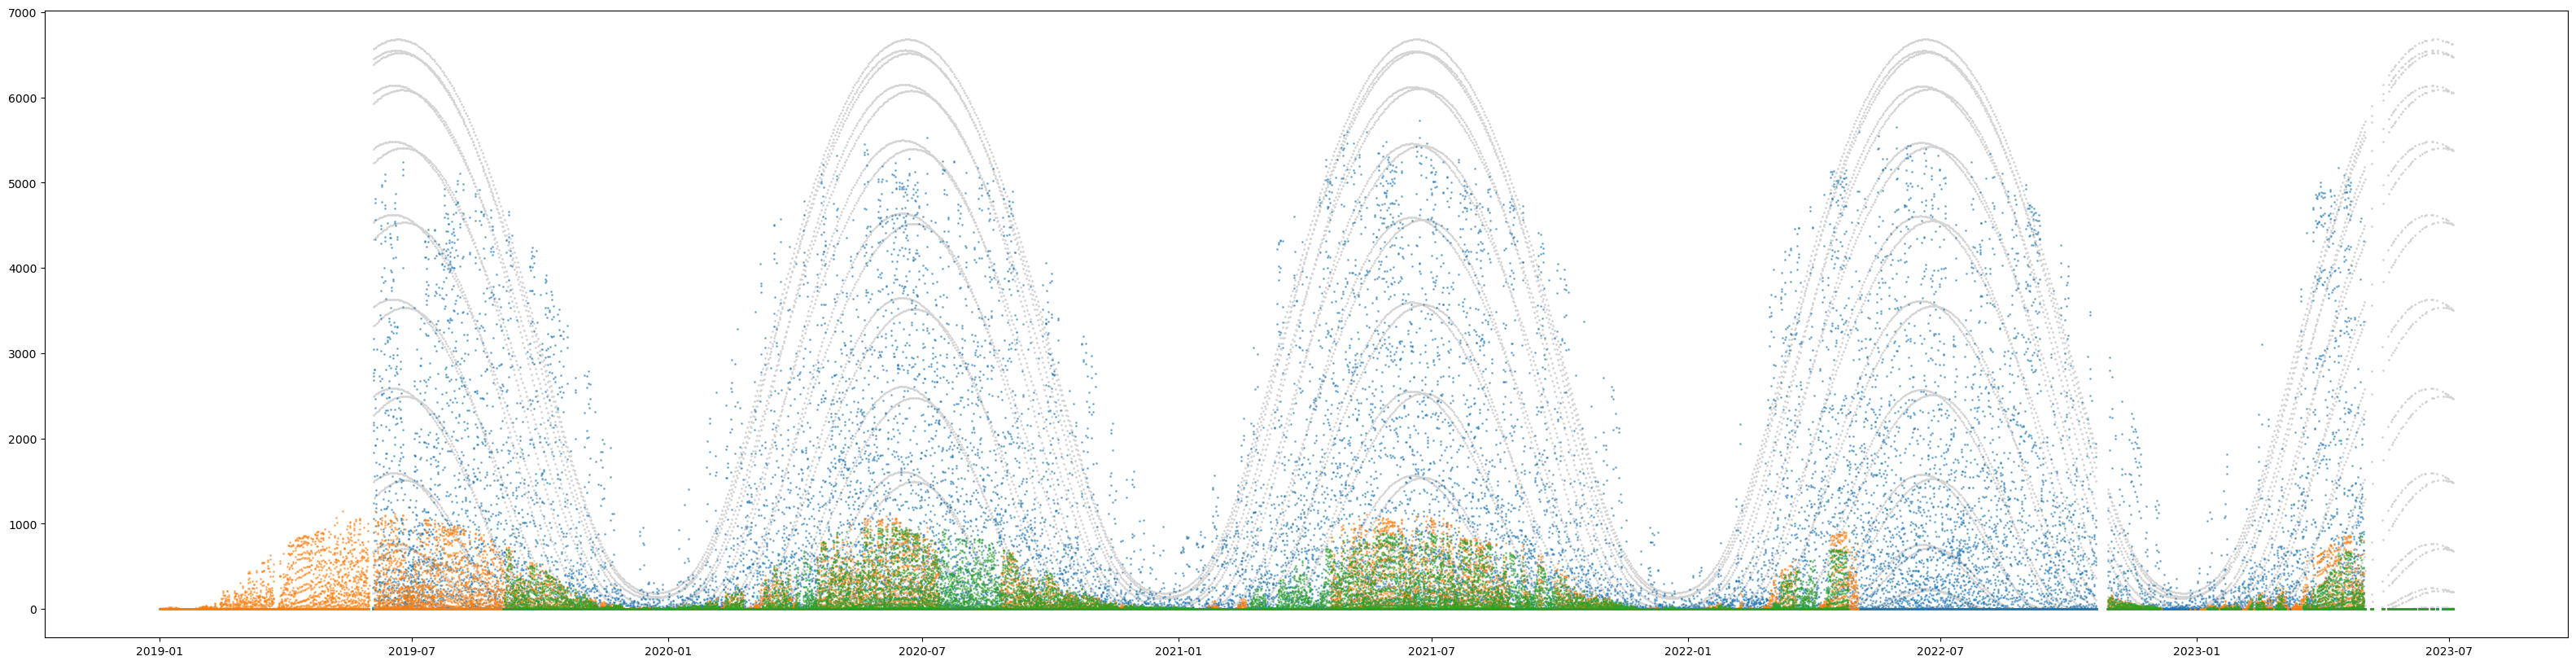

In [122]:
# Plot alignment and values
plt.figure(figsize=(40, 10))

plt.scatter(
    data_simple[data_simple.location == "A"].date_forecast,
    data_simple[data_simple.location == "A"]["clear_sky_rad:W"] * 8,
    s=1,
    color="lightgrey",
)

for loc in locations:
    plt.scatter(
        data_simple[data_simple.location == loc].date_forecast,
        data_simple[data_simple.location == loc]["pv_measurement"],
        s=1,
        alpha=0.5,
    )

# 2 – Modeling

**Model Stack**
1. Target Encoded Catboost
2. Simple LightGBM
3. Target Log Transform Catboost
4. Location Specific Catboost
6. Location Specific Catboost 2
7. Location Specific Catboost 3
8. Location Specific Catboost 4
9. Location Specific Catboost 5
10. Location Specific Catboost 6
11. Location Specific Catboost 7
12. Location Specific Catboost 8
13. Location Specific Catboost 9
14. Location Specific Catboost 10
15. Location Specific AutoGluon
16. Location Specific FastAI Neural Network

In [123]:
# Dictionary of all model predictions for final ensambling
test_result = {}

In [125]:
def scale_data(data, cols=None):
    if cols is None:
        ignore_cols = [
            "location",
            "dew_or_rime:idx",
            "is_day:idx",
            "is_in_shadow:idx",
            "pv_measurement",
            "data_type",
        ]

        cols = [col for col in data.columns if col not in ignore_cols]

    X_scaler = MinMaxScaler()
    X_scaler = X_scaler.fit(
        data[data["data_type"].isin(["observed", "estimated"])][cols]
    )
    y_scaler = MinMaxScaler()
    y_scaler = y_scaler.fit(
        data[data["data_type"].isin(["observed", "estimated"])][["pv_measurement"]]
    )

    data_copy = data.copy()

    data_copy[cols] = X_scaler.transform(data_copy[cols])
    data_copy[["pv_measurement"]] = y_scaler.transform(data[["pv_measurement"]])

    return data_copy, X_scaler, y_scaler

In [126]:
# function that transforms sun elevation:
def transform_sun_elevation(df, feature):
    amplitude = 50
    df[feature +"sin"] = amplitude*np.sin((2*np.pi/365)*df["date_forecast"].dt.dayofyear)
    df[feature +"sin"] = amplitude*np.cos((2*np.pi/365)*df["date_forecast"].dt.dayofyear)
    return df

## Model 1 – Target Encoded Catboost

In [127]:
data_general_catboost_target_encoded = data_simple.copy()

#transform sun elevation by function
data_general_catboost_target_encoded = transform_sun_elevation(data_general_catboost_target_encoded, "sun_elevation:d")
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
    "sun_elevation:d",
]

mean_target = (
    data_general_catboost_target_encoded[
        data_general_catboost_target_encoded.data_type.isin(["observed", "estimated"])
    ]
    .groupby(["location", "month", "hour"])["pv_measurement"]
    .mean()
)

location_mapping = mean_target.to_dict()

data_general_catboost_target_encoded[
    "location_encoded"
] = data_general_catboost_target_encoded.apply(
    lambda x: location_mapping.get((x["location"], x["month"], x["hour"]), None), axis=1
)

data_general_catboost_target_encoded = data_general_catboost_target_encoded.drop(
    drop_cols, axis=1
)

data_general_catboost_target_encoded, _, y_scaler = scale_data(
    data_general_catboost_target_encoded
)

# Create training and test data
train = (
    data_general_catboost_target_encoded[
        data_general_catboost_target_encoded["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)
test = (
    data_general_catboost_target_encoded[
        data_general_catboost_target_encoded["data_type"] == "test"
    ]
    .drop(columns=["data_type"])
    .copy()
)

In [128]:
pv_measurement = train["pv_measurement"]

cat_features = [0]
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "cat_features": cat_features,
    "random_state": 25
}

# Initialize lists to store the predictions
all_preds = pd.DataFrame()
temp_test_result = []

# Create a CatBoostRegressor instance for this fold
model = cb.CatBoostRegressor(**model_params)

# Fit the model
model.fit(train.drop("pv_measurement", axis=1), pv_measurement)

# Get predictions for the validation set
preds = model.predict(test)

0:	learn: 0.0504075	total: 119ms	remaining: 1m 58s
1:	learn: 0.0492362	total: 248ms	remaining: 2m 3s
2:	learn: 0.0481295	total: 334ms	remaining: 1m 50s
3:	learn: 0.0475385	total: 441ms	remaining: 1m 49s
4:	learn: 0.0464448	total: 531ms	remaining: 1m 45s
5:	learn: 0.0455389	total: 655ms	remaining: 1m 48s
6:	learn: 0.0444846	total: 755ms	remaining: 1m 47s
7:	learn: 0.0439472	total: 932ms	remaining: 1m 55s
8:	learn: 0.0430400	total: 1s	remaining: 1m 50s
9:	learn: 0.0424605	total: 1.1s	remaining: 1m 49s
10:	learn: 0.0418874	total: 1.19s	remaining: 1m 46s
11:	learn: 0.0409818	total: 1.37s	remaining: 1m 52s
12:	learn: 0.0402231	total: 1.45s	remaining: 1m 50s
13:	learn: 0.0392845	total: 1.57s	remaining: 1m 50s
14:	learn: 0.0384605	total: 1.66s	remaining: 1m 49s
15:	learn: 0.0376208	total: 1.74s	remaining: 1m 46s
16:	learn: 0.0371310	total: 1.87s	remaining: 1m 48s
17:	learn: 0.0362959	total: 2.12s	remaining: 1m 55s
18:	learn: 0.0355181	total: 2.29s	remaining: 1m 58s
19:	learn: 0.0349465	total:

In [129]:
test_result["encoded_catboost"] = pd.DataFrame(
    y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"]
)
test_result["encoded_catboost"]["location"] = data_simple[
    data_simple.data_type == "test"
].location.to_list()
test_result["encoded_catboost"] = (
    test_result["encoded_catboost"]
    .reset_index()
    .sort_values(["location", "index"])["pv_measurement"]
)

## Model 2 – Simple LightGBM

In [131]:
data_general_lgb = data_simple.copy()
#transform sun elevation by function
data_general_lgb = transform_sun_elevation(data_general_lgb, "sun_elevation:d")
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "month_sin",
    "hour_sin",
    "month_cos",
    "hour_cos",
    "date_calc",
    "sun_azimuth:d_sin",
    "sun_azimuth:d_cos",
    "date_forecast",
    "elevation:m",
    "precip_5min:mm",
    "precip_type_5min:idx",
    "snow_drift:idx",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms",
    "wind_speed_w_1000hPa:ms",
    "sun_elevation:d",
    
]

data_general_lgb = data_general_lgb.drop(drop_cols, axis=1)
data_general_lgb.columns = [
    column.replace(":", "_") for column in data_general_lgb.columns
]

ignore_cols = [
    "location",
    "is_day_idx",
    "is_in_shadow_idx",
    "pv_measurement",
    "data_type",
]

data_general_lgb["is_day_idx"] = data_general_lgb["is_day_idx"].astype("int")
data_general_lgb["is_in_shadow_idx"] = data_general_lgb["is_in_shadow_idx"].astype("int")
data_general_lgb["dew_or_rime_idx"] = data_general_lgb["dew_or_rime_idx"].astype("int")

cols = [col for col in data_general_lgb.columns if col not in ignore_cols]

data_general_lgb, _, y_scaler = scale_data(data_general_lgb, cols=cols)

# location one-hot
data_general_lgb = pd.get_dummies(data_general_lgb, columns=["location"])

# Create training and test data
test = data_general_lgb[data_general_lgb["data_type"].isin(["test"])].drop(columns=["data_type"]).copy()
train = data_general_lgb[data_general_lgb["data_type"].isin(["observed", "estimated"])].drop(columns=["data_type"]).copy()

In [132]:
pv_measurement = train["pv_measurement"]

model_params = {
    "metric": "MSE",
    "max_depth": 6,
    "num_rounds": 200,
    "colsample_bytree": 0.6,
    "learning_rate": 0.04,
    "num_leaves": 140,
    "random_state": 0
}

# Create a CatBoostRegressor instance for this fold
model = lgb.LGBMRegressor(**model_params)

# Fit the model
model.fit(train.drop(columns=["pv_measurement"]), pv_measurement)

# Get predictions for the validation set
preds = model.predict(test.drop(columns=["pv_measurement"]))

/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200


In [133]:
test_result["general_lightgbm"] = pd.DataFrame(
    y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"]
)
test_result["general_lightgbm"]["location"] = data_simple[
    data_simple.data_type == "test"
].location.to_list()
test_result["general_lightgbm"] = (
    test_result["general_lightgbm"]
    .reset_index()
    .sort_values(["location", "index"])["pv_measurement"]
)

## Model 3 – Target Log Transform Catboost

In [135]:
data_general_catboost_transform = data_simple.copy()

#transform sun elevation by function
data_general_catboost_transform = transform_sun_elevation(data_general_catboost_transform, "sun_elevation:d")


# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
    "sun_elevation:d",
]

data_general_catboost_transform["pv_measurement"] = np.log1p(
    data_general_catboost_transform["pv_measurement"]
)

data_general_catboost_transform = data_general_catboost_transform.drop(
    drop_cols, axis=1
)

data_general_catboost_transform, _, y_scaler = scale_data(
    data_general_catboost_transform
)

# Create training and test data
train = (
    data_general_catboost_transform[
        data_general_catboost_transform["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)
test = (
    data_general_catboost_transform[
        data_general_catboost_transform["data_type"] == "test"
    ]
    .drop(columns=["data_type"])
    .copy()
)

In [136]:
pv_measurement = train["pv_measurement"]

cat_features = [0]
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "cat_features": cat_features,
    "random_state": 185
}

# For final predictions
# Create a CatBoostRegressor instance for this fold
model = cb.CatBoostRegressor(**model_params)

# Fit the model
model.fit(train.drop("pv_measurement", axis=1), pv_measurement)

# Get predictions for the validation set
preds = model.predict(test)

0:	learn: 0.2611187	total: 45ms	remaining: 44.9s
1:	learn: 0.2536905	total: 84.2ms	remaining: 42s
2:	learn: 0.2465762	total: 127ms	remaining: 42.1s
3:	learn: 0.2395271	total: 166ms	remaining: 41.3s
4:	learn: 0.2328329	total: 207ms	remaining: 41.2s
5:	learn: 0.2262364	total: 247ms	remaining: 41s
6:	learn: 0.2199247	total: 288ms	remaining: 40.9s
7:	learn: 0.2137146	total: 326ms	remaining: 40.5s
8:	learn: 0.2077252	total: 371ms	remaining: 40.9s
9:	learn: 0.2019508	total: 409ms	remaining: 40.4s
10:	learn: 0.1964137	total: 445ms	remaining: 40s
11:	learn: 0.1909708	total: 482ms	remaining: 39.7s
12:	learn: 0.1856781	total: 523ms	remaining: 39.7s
13:	learn: 0.1805629	total: 561ms	remaining: 39.5s
14:	learn: 0.1756019	total: 597ms	remaining: 39.2s
15:	learn: 0.1708366	total: 637ms	remaining: 39.2s
16:	learn: 0.1662315	total: 677ms	remaining: 39.1s
17:	learn: 0.1617277	total: 713ms	remaining: 38.9s
18:	learn: 0.1573474	total: 753ms	remaining: 38.9s
19:	learn: 0.1531142	total: 794ms	remaining: 38

In [137]:
test_result["transform_catboost"] = pd.DataFrame(
    y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"]
)
test_result["transform_catboost"]["pv_measurement"] = np.expm1(
    test_result["transform_catboost"].values
)
test_result["transform_catboost"]["location"] = data_simple[
    data_simple.data_type == "test"
].location.to_list()
test_result["transform_catboost"] = (
    test_result["transform_catboost"]
    .reset_index()
    .sort_values(["location", "index"])["pv_measurement"]
)

## Model 4 – Location Specific Catboost

In [138]:
catboost_location = data_simple.copy()


# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

catboost_location = catboost_location.drop(drop_cols, axis=1)
catboost_location["estimated"] = np.where(
    catboost_location.data_type.isin(["estimated", "test"]), 1, 0
)

# Create training and test data
train_all = catboost_location[catboost_location.data_type.isin(["observed", "estimated"])].drop(columns="data_type").copy()
test = catboost_location[catboost_location.data_type == "test"].drop(columns="data_type").copy()

In [139]:
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "random_state": 137
}

final_preds = []

for location in ("A", "B", "C"):
    train = train_all[train_all.location == location].drop(columns=["location"])

    train_pool = cb.Pool(data=train.drop(columns="pv_measurement"), label=train["pv_measurement"], cat_features=["estimated"])
    test_pool = cb.Pool(data=test[test.location == location].drop(columns=["pv_measurement", "location"]), cat_features=["estimated"])

    # Create a CatBoostRegressor instance for this fold
    model = cb.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_pool)

    # Get predictions for the validation set
    preds = model.predict(test_pool)

    # Invert scaling for the validation set predictions
    prediction_df = pd.DataFrame(preds, columns=["prediction"], index=test[test.location == location].index)
    prediction_df["location"] = location

    # Append the predictions to the list
    final_preds.append(prediction_df)

0:	learn: 620.3388824	total: 27.2ms	remaining: 27.2s
1:	learn: 606.1575620	total: 50.8ms	remaining: 25.3s
2:	learn: 591.8429553	total: 68ms	remaining: 22.6s
3:	learn: 577.6753791	total: 83.7ms	remaining: 20.8s
4:	learn: 563.0154477	total: 107ms	remaining: 21.3s
5:	learn: 550.2404768	total: 147ms	remaining: 24.4s
6:	learn: 538.5398277	total: 172ms	remaining: 24.4s
7:	learn: 527.4039151	total: 193ms	remaining: 24s
8:	learn: 515.2903120	total: 211ms	remaining: 23.2s
9:	learn: 502.6256789	total: 227ms	remaining: 22.5s
10:	learn: 490.9396355	total: 243ms	remaining: 21.8s
11:	learn: 479.7081745	total: 285ms	remaining: 23.5s
12:	learn: 468.2919131	total: 307ms	remaining: 23.3s
13:	learn: 459.9118837	total: 326ms	remaining: 23s
14:	learn: 450.0215271	total: 346ms	remaining: 22.7s
15:	learn: 440.3177462	total: 364ms	remaining: 22.4s
16:	learn: 431.1667576	total: 381ms	remaining: 22s
17:	learn: 421.8120387	total: 397ms	remaining: 21.6s
18:	learn: 413.3741740	total: 415ms	remaining: 21.4s
19:	lea

In [140]:
test_result["location_catboost"] = pd.concat(final_preds).reset_index().sort_values(["location", "index"]).drop(columns="index")["prediction"]

## Model 5 - Location Specific Catboost 2

In [141]:
catboost_location = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

catboost_location = catboost_location.drop(drop_cols, axis=1)
catboost_location["estimated"] = np.where(
    catboost_location.data_type.isin(["estimated", "test"]), 1, 0
)

# Create training and test data
train_all = catboost_location[catboost_location.data_type.isin(["observed", "estimated"])].drop(columns="data_type").copy()
test = catboost_location[catboost_location.data_type == "test"].drop(columns="data_type").copy()

In [142]:
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "random_state": 138
}

final_preds = []

for location in ("A", "B", "C"):
    train = train_all[train_all.location == location].drop(columns=["location"])

    train_pool = cb.Pool(data=train.drop(columns="pv_measurement"), label=train["pv_measurement"], cat_features=["estimated"])
    test_pool = cb.Pool(data=test[test.location == location].drop(columns=["pv_measurement", "location"]), cat_features=["estimated"])

    # Create a CatBoostRegressor instance for this fold
    model = cb.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_pool)

    # Get predictions for the validation set
    preds = model.predict(test_pool)

    # Invert scaling for the validation set predictions
    prediction_df = pd.DataFrame(preds, columns=["prediction"], index=test[test.location == location].index)
    prediction_df["location"] = location

    # Append the predictions to the list
    final_preds.append(prediction_df)

0:	learn: 617.8767504	total: 20ms	remaining: 20s
1:	learn: 603.0032368	total: 39ms	remaining: 19.4s
2:	learn: 588.8284872	total: 55.3ms	remaining: 18.4s
3:	learn: 574.5176766	total: 71.5ms	remaining: 17.8s
4:	learn: 562.0669705	total: 89.1ms	remaining: 17.7s
5:	learn: 548.9408528	total: 104ms	remaining: 17.3s
6:	learn: 536.7513616	total: 120ms	remaining: 17s
7:	learn: 523.0506662	total: 134ms	remaining: 16.6s
8:	learn: 511.8981319	total: 149ms	remaining: 16.4s
9:	learn: 501.0827272	total: 164ms	remaining: 16.2s
10:	learn: 488.7560823	total: 179ms	remaining: 16.1s
11:	learn: 477.9147867	total: 195ms	remaining: 16s
12:	learn: 468.1097519	total: 236ms	remaining: 17.9s
13:	learn: 458.2573920	total: 260ms	remaining: 18.3s
14:	learn: 448.0290642	total: 274ms	remaining: 18s
15:	learn: 438.9201649	total: 289ms	remaining: 17.8s
16:	learn: 429.8408952	total: 303ms	remaining: 17.5s
17:	learn: 420.0625889	total: 318ms	remaining: 17.4s
18:	learn: 410.6180810	total: 332ms	remaining: 17.2s
19:	learn:

In [143]:
test_result["location_catboost_2"] = pd.concat(final_preds).reset_index().sort_values(["location", "index"]).drop(columns="index")["prediction"]

## Model 6 - Location Specific Catboost 3

In [144]:
catboost_location = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

catboost_location = catboost_location.drop(drop_cols, axis=1)
catboost_location["estimated"] = np.where(
    catboost_location.data_type.isin(["estimated", "test"]), 1, 0
)

# Create training and test data
train_all = catboost_location[catboost_location.data_type.isin(["observed", "estimated"])].drop(columns="data_type").copy()
test = catboost_location[catboost_location.data_type == "test"].drop(columns="data_type").copy()

In [145]:
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "random_state": 142
}

final_preds = []

for location in ("A", "B", "C"):
    train = train_all[train_all.location == location].drop(columns=["location"])

    train_pool = cb.Pool(data=train.drop(columns="pv_measurement"), label=train["pv_measurement"], cat_features=["estimated"])
    test_pool = cb.Pool(data=test[test.location == location].drop(columns=["pv_measurement", "location"]), cat_features=["estimated"])

    # Create a CatBoostRegressor instance for this fold
    model = cb.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_pool)

    # Get predictions for the validation set
    preds = model.predict(test_pool)

    # Invert scaling for the validation set predictions
    prediction_df = pd.DataFrame(preds, columns=["prediction"], index=test[test.location == location].index)
    prediction_df["location"] = location

    # Append the predictions to the list
    final_preds.append(prediction_df)

0:	learn: 615.0016147	total: 20.8ms	remaining: 20.7s
1:	learn: 600.0841279	total: 40.1ms	remaining: 20s
2:	learn: 587.6030377	total: 58.5ms	remaining: 19.4s
3:	learn: 577.0752282	total: 111ms	remaining: 27.6s
4:	learn: 564.2051389	total: 141ms	remaining: 28s
5:	learn: 552.8790464	total: 159ms	remaining: 26.4s
6:	learn: 540.1635559	total: 178ms	remaining: 25.2s
7:	learn: 528.9539895	total: 194ms	remaining: 24s
8:	learn: 518.2148373	total: 210ms	remaining: 23.2s
9:	learn: 506.7727596	total: 226ms	remaining: 22.4s
10:	learn: 493.9301711	total: 243ms	remaining: 21.8s
11:	learn: 482.0397764	total: 258ms	remaining: 21.3s
12:	learn: 470.2984656	total: 277ms	remaining: 21s
13:	learn: 459.9224314	total: 294ms	remaining: 20.7s
14:	learn: 450.1206435	total: 311ms	remaining: 20.4s
15:	learn: 441.4208312	total: 327ms	remaining: 20.1s
16:	learn: 431.5607421	total: 343ms	remaining: 19.8s
17:	learn: 423.7782903	total: 359ms	remaining: 19.6s
18:	learn: 415.0318285	total: 374ms	remaining: 19.3s
19:	lear

In [146]:
test_result["location_catboost_3"] = pd.concat(final_preds).reset_index().sort_values(["location", "index"]).drop(columns="index")["prediction"]

## Model 7 - Location Specific Catboost 4

In [147]:
catboost_location = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

catboost_location = catboost_location.drop(drop_cols, axis=1)
catboost_location["estimated"] = np.where(
    catboost_location.data_type.isin(["estimated", "test"]), 1, 0
)

# Create training and test data
train_all = catboost_location[catboost_location.data_type.isin(["observed", "estimated"])].drop(columns="data_type").copy()
test = catboost_location[catboost_location.data_type == "test"].drop(columns="data_type").copy()

In [148]:
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "random_state": 121
}

final_preds = []

for location in ("A", "B", "C"):
    train = train_all[train_all.location == location].drop(columns=["location"])

    train_pool = cb.Pool(data=train.drop(columns="pv_measurement"), label=train["pv_measurement"], cat_features=["estimated"])
    test_pool = cb.Pool(data=test[test.location == location].drop(columns=["pv_measurement", "location"]), cat_features=["estimated"])

    # Create a CatBoostRegressor instance for this fold
    model = cb.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_pool)

    # Get predictions for the validation set
    preds = model.predict(test_pool)

    # Invert scaling for the validation set predictions
    prediction_df = pd.DataFrame(preds, columns=["prediction"], index=test[test.location == location].index)
    prediction_df["location"] = location

    # Append the predictions to the list
    final_preds.append(prediction_df)

0:	learn: 615.5737339	total: 61.6ms	remaining: 1m 1s
1:	learn: 602.6006158	total: 88.9ms	remaining: 44.4s
2:	learn: 589.0925330	total: 109ms	remaining: 36.3s
3:	learn: 575.8121849	total: 128ms	remaining: 31.9s
4:	learn: 564.2265975	total: 146ms	remaining: 29.1s
5:	learn: 551.8455524	total: 163ms	remaining: 26.9s
6:	learn: 539.3580889	total: 183ms	remaining: 25.9s
7:	learn: 526.2456444	total: 200ms	remaining: 24.7s
8:	learn: 512.8718845	total: 217ms	remaining: 23.9s
9:	learn: 500.0629121	total: 235ms	remaining: 23.3s
10:	learn: 487.6371149	total: 252ms	remaining: 22.7s
11:	learn: 475.8327756	total: 269ms	remaining: 22.1s
12:	learn: 467.3778241	total: 287ms	remaining: 21.8s
13:	learn: 457.0465191	total: 300ms	remaining: 21.1s
14:	learn: 446.4999701	total: 317ms	remaining: 20.8s
15:	learn: 436.7341291	total: 333ms	remaining: 20.5s
16:	learn: 427.9308247	total: 350ms	remaining: 20.2s
17:	learn: 418.6576372	total: 365ms	remaining: 19.9s
18:	learn: 410.1091743	total: 382ms	remaining: 19.7s
1

In [149]:
test_result["location_catboost_4"] = pd.concat(final_preds).reset_index().sort_values(["location", "index"]).drop(columns="index")["prediction"]

## Model 8 - Location Specific Catboost 5

In [150]:
catboost_location = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

catboost_location = catboost_location.drop(drop_cols, axis=1)
catboost_location["estimated"] = np.where(
    catboost_location.data_type.isin(["estimated", "test"]), 1, 0
)

# Create training and test data
train_all = catboost_location[catboost_location.data_type.isin(["observed", "estimated"])].drop(columns="data_type").copy()
test = catboost_location[catboost_location.data_type == "test"].drop(columns="data_type").copy()

In [151]:
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "random_state": 12
}

final_preds = []

for location in ("A", "B", "C"):
    train = train_all[train_all.location == location].drop(columns=["location"])

    train_pool = cb.Pool(data=train.drop(columns="pv_measurement"), label=train["pv_measurement"], cat_features=["estimated"])
    test_pool = cb.Pool(data=test[test.location == location].drop(columns=["pv_measurement", "location"]), cat_features=["estimated"])

    # Create a CatBoostRegressor instance for this fold
    model = cb.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_pool)

    # Get predictions for the validation set
    preds = model.predict(test_pool)

    # Invert scaling for the validation set predictions
    prediction_df = pd.DataFrame(preds, columns=["prediction"], index=test[test.location == location].index)
    prediction_df["location"] = location

    # Append the predictions to the list
    final_preds.append(prediction_df)

0:	learn: 617.6175958	total: 27.3ms	remaining: 27.2s
1:	learn: 603.5664246	total: 47.9ms	remaining: 23.9s
2:	learn: 588.3772720	total: 67.5ms	remaining: 22.4s
3:	learn: 573.9034027	total: 85.5ms	remaining: 21.3s
4:	learn: 562.6112643	total: 105ms	remaining: 20.9s
5:	learn: 549.3916915	total: 125ms	remaining: 20.7s
6:	learn: 536.0648240	total: 143ms	remaining: 20.3s
7:	learn: 524.7964346	total: 160ms	remaining: 19.8s
8:	learn: 512.9091263	total: 173ms	remaining: 19.1s
9:	learn: 500.1777396	total: 190ms	remaining: 18.9s
10:	learn: 488.0371555	total: 210ms	remaining: 18.9s
11:	learn: 477.4188947	total: 228ms	remaining: 18.7s
12:	learn: 465.5092194	total: 246ms	remaining: 18.6s
13:	learn: 454.9543480	total: 263ms	remaining: 18.5s
14:	learn: 444.5614303	total: 281ms	remaining: 18.4s
15:	learn: 434.6019835	total: 297ms	remaining: 18.3s
16:	learn: 424.4936979	total: 315ms	remaining: 18.2s
17:	learn: 415.6687307	total: 331ms	remaining: 18.1s
18:	learn: 406.9604565	total: 347ms	remaining: 17.9s

In [152]:
test_result["location_catboost_5"] = pd.concat(final_preds).reset_index().sort_values(["location", "index"]).drop(columns="index")["prediction"]

## Model 9 - Location Specific Catboost 6

In [153]:
catboost_location = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

catboost_location = catboost_location.drop(drop_cols, axis=1)
catboost_location["estimated"] = np.where(
    catboost_location.data_type.isin(["estimated", "test"]), 1, 0
)

# Create training and test data
train_all = catboost_location[catboost_location.data_type.isin(["observed", "estimated"])].drop(columns="data_type").copy()
test = catboost_location[catboost_location.data_type == "test"].drop(columns="data_type").copy()

In [154]:
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "random_state": 42
}

final_preds = []

for location in ("A", "B", "C"):
    train = train_all[train_all.location == location].drop(columns=["location"])

    train_pool = cb.Pool(data=train.drop(columns="pv_measurement"), label=train["pv_measurement"], cat_features=["estimated"])
    test_pool = cb.Pool(data=test[test.location == location].drop(columns=["pv_measurement", "location"]), cat_features=["estimated"])

    # Create a CatBoostRegressor instance for this fold
    model = cb.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_pool)

    # Get predictions for the validation set
    preds = model.predict(test_pool)

    # Invert scaling for the validation set predictions
    prediction_df = pd.DataFrame(preds, columns=["prediction"], index=test[test.location == location].index)
    prediction_df["location"] = location

    # Append the predictions to the list
    final_preds.append(prediction_df)

0:	learn: 615.1335581	total: 24.8ms	remaining: 24.8s
1:	learn: 598.9382734	total: 44.3ms	remaining: 22.1s
2:	learn: 586.0903571	total: 62.9ms	remaining: 20.9s
3:	learn: 572.8101060	total: 81.3ms	remaining: 20.3s
4:	learn: 558.7556490	total: 134ms	remaining: 26.7s
5:	learn: 545.6687849	total: 162ms	remaining: 26.8s
6:	learn: 532.1698889	total: 179ms	remaining: 25.4s
7:	learn: 520.2257163	total: 196ms	remaining: 24.3s
8:	learn: 507.9108019	total: 213ms	remaining: 23.4s
9:	learn: 495.4827681	total: 230ms	remaining: 22.7s
10:	learn: 484.0325800	total: 248ms	remaining: 22.3s
11:	learn: 473.7956091	total: 265ms	remaining: 21.8s
12:	learn: 463.9168782	total: 281ms	remaining: 21.4s
13:	learn: 454.1283666	total: 303ms	remaining: 21.3s
14:	learn: 446.4770547	total: 321ms	remaining: 21.1s
15:	learn: 436.2438965	total: 339ms	remaining: 20.8s
16:	learn: 427.4195500	total: 354ms	remaining: 20.5s
17:	learn: 417.5946291	total: 371ms	remaining: 20.2s
18:	learn: 410.0735832	total: 388ms	remaining: 20s
1

In [155]:
test_result["location_catboost_6"] = pd.concat(final_preds).reset_index().sort_values(["location", "index"]).drop(columns="index")["prediction"]

## Model 10 - Location Specific Catboost 7

In [156]:
catboost_location = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

catboost_location = catboost_location.drop(drop_cols, axis=1)
catboost_location["estimated"] = np.where(
    catboost_location.data_type.isin(["estimated", "test"]), 1, 0
)

# Create training and test data
train_all = catboost_location[catboost_location.data_type.isin(["observed", "estimated"])].drop(columns="data_type").copy()
test = catboost_location[catboost_location.data_type == "test"].drop(columns="data_type").copy()

In [157]:
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "random_state": 114
}

final_preds = []

for location in ("A", "B", "C"):
    train = train_all[train_all.location == location].drop(columns=["location"])

    train_pool = cb.Pool(data=train.drop(columns="pv_measurement"), label=train["pv_measurement"], cat_features=["estimated"])
    test_pool = cb.Pool(data=test[test.location == location].drop(columns=["pv_measurement", "location"]), cat_features=["estimated"])

    # Create a CatBoostRegressor instance for this fold
    model = cb.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_pool)

    # Get predictions for the validation set
    preds = model.predict(test_pool)

    # Invert scaling for the validation set predictions
    prediction_df = pd.DataFrame(preds, columns=["prediction"], index=test[test.location == location].index)
    prediction_df["location"] = location

    # Append the predictions to the list
    final_preds.append(prediction_df)

0:	learn: 617.1665846	total: 28.1ms	remaining: 28.1s
1:	learn: 603.8263243	total: 49.9ms	remaining: 24.9s
2:	learn: 590.1490993	total: 73ms	remaining: 24.2s
3:	learn: 575.8656577	total: 117ms	remaining: 29.1s
4:	learn: 563.1396644	total: 157ms	remaining: 31.2s
5:	learn: 551.2262714	total: 174ms	remaining: 28.8s
6:	learn: 538.3674172	total: 193ms	remaining: 27.3s
7:	learn: 526.6806899	total: 209ms	remaining: 25.9s
8:	learn: 513.6858260	total: 226ms	remaining: 24.9s
9:	learn: 501.0986180	total: 244ms	remaining: 24.2s
10:	learn: 489.7068402	total: 260ms	remaining: 23.4s
11:	learn: 477.7401128	total: 278ms	remaining: 22.9s
12:	learn: 466.9151735	total: 295ms	remaining: 22.4s
13:	learn: 457.9283957	total: 312ms	remaining: 21.9s
14:	learn: 448.4477727	total: 330ms	remaining: 21.7s
15:	learn: 438.1237253	total: 349ms	remaining: 21.4s
16:	learn: 428.4962379	total: 365ms	remaining: 21.1s
17:	learn: 419.2993961	total: 381ms	remaining: 20.8s
18:	learn: 410.0392089	total: 397ms	remaining: 20.5s
19

In [158]:
test_result["location_catboost_7"] = pd.concat(final_preds).reset_index().sort_values(["location", "index"]).drop(columns="index")["prediction"]

## Model 11 - Location Specific Catboost 8

In [159]:
catboost_location = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

catboost_location = catboost_location.drop(drop_cols, axis=1)
catboost_location["estimated"] = np.where(
    catboost_location.data_type.isin(["estimated", "test"]), 1, 0
)

# Create training and test data
train_all = catboost_location[catboost_location.data_type.isin(["observed", "estimated"])].drop(columns="data_type").copy()
test = catboost_location[catboost_location.data_type == "test"].drop(columns="data_type").copy()

In [160]:
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "random_state": 157
}

final_preds = []

for location in ("A", "B", "C"):
    train = train_all[train_all.location == location].drop(columns=["location"])

    train_pool = cb.Pool(data=train.drop(columns="pv_measurement"), label=train["pv_measurement"], cat_features=["estimated"])
    test_pool = cb.Pool(data=test[test.location == location].drop(columns=["pv_measurement", "location"]), cat_features=["estimated"])

    # Create a CatBoostRegressor instance for this fold
    model = cb.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_pool)

    # Get predictions for the validation set
    preds = model.predict(test_pool)

    # Invert scaling for the validation set predictions
    prediction_df = pd.DataFrame(preds, columns=["prediction"], index=test[test.location == location].index)
    prediction_df["location"] = location

    # Append the predictions to the list
    final_preds.append(prediction_df)

0:	learn: 617.2918341	total: 22.2ms	remaining: 22.2s
1:	learn: 603.7239067	total: 57.9ms	remaining: 28.9s
2:	learn: 589.0146673	total: 102ms	remaining: 33.8s
3:	learn: 576.3801306	total: 170ms	remaining: 42.4s
4:	learn: 562.4374908	total: 208ms	remaining: 41.5s
5:	learn: 548.7731820	total: 231ms	remaining: 38.2s
6:	learn: 536.6305270	total: 252ms	remaining: 35.7s
7:	learn: 523.8306040	total: 271ms	remaining: 33.6s
8:	learn: 512.9918792	total: 291ms	remaining: 32s
9:	learn: 500.6611571	total: 309ms	remaining: 30.6s
10:	learn: 489.4445936	total: 332ms	remaining: 29.9s
11:	learn: 478.5667676	total: 351ms	remaining: 28.9s
12:	learn: 466.9119853	total: 367ms	remaining: 27.9s
13:	learn: 456.4349577	total: 383ms	remaining: 27s
14:	learn: 447.1214970	total: 399ms	remaining: 26.2s
15:	learn: 437.4009182	total: 414ms	remaining: 25.5s
16:	learn: 427.4264300	total: 432ms	remaining: 25s
17:	learn: 419.7903624	total: 447ms	remaining: 24.4s
18:	learn: 413.0351231	total: 464ms	remaining: 24s
19:	learn

In [161]:
test_result["location_catboost_8"] = pd.concat(final_preds).reset_index().sort_values(["location", "index"]).drop(columns="index")["prediction"]

## Model 12 - Location Specific Catboost 9

In [162]:
catboost_location = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

catboost_location = catboost_location.drop(drop_cols, axis=1)
catboost_location["estimated"] = np.where(
    catboost_location.data_type.isin(["estimated", "test"]), 1, 0
)

# Create training and test data
train_all = catboost_location[catboost_location.data_type.isin(["observed", "estimated"])].drop(columns="data_type").copy()
test = catboost_location[catboost_location.data_type == "test"].drop(columns="data_type").copy()

In [163]:
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "random_state": 69
}

final_preds = []

for location in ("A", "B", "C"):
    train = train_all[train_all.location == location].drop(columns=["location"])

    train_pool = cb.Pool(data=train.drop(columns="pv_measurement"), label=train["pv_measurement"], cat_features=["estimated"])
    test_pool = cb.Pool(data=test[test.location == location].drop(columns=["pv_measurement", "location"]), cat_features=["estimated"])

    # Create a CatBoostRegressor instance for this fold
    model = cb.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_pool)

    # Get predictions for the validation set
    preds = model.predict(test_pool)

    # Invert scaling for the validation set predictions
    prediction_df = pd.DataFrame(preds, columns=["prediction"], index=test[test.location == location].index)
    prediction_df["location"] = location

    # Append the predictions to the list
    final_preds.append(prediction_df)

0:	learn: 614.3457067	total: 25.4ms	remaining: 25.4s
1:	learn: 598.6214939	total: 45.3ms	remaining: 22.6s
2:	learn: 584.5592386	total: 64.1ms	remaining: 21.3s
3:	learn: 574.6611851	total: 120ms	remaining: 29.9s
4:	learn: 560.2995277	total: 142ms	remaining: 28.3s
5:	learn: 549.0856681	total: 159ms	remaining: 26.3s
6:	learn: 535.9714224	total: 175ms	remaining: 24.8s
7:	learn: 523.9596786	total: 192ms	remaining: 23.8s
8:	learn: 511.1416345	total: 207ms	remaining: 22.8s
9:	learn: 499.4978495	total: 223ms	remaining: 22.1s
10:	learn: 489.2926470	total: 239ms	remaining: 21.5s
11:	learn: 478.8986644	total: 258ms	remaining: 21.2s
12:	learn: 467.7059034	total: 274ms	remaining: 20.8s
13:	learn: 456.9039403	total: 289ms	remaining: 20.4s
14:	learn: 448.0781965	total: 305ms	remaining: 20s
15:	learn: 437.8135968	total: 320ms	remaining: 19.7s
16:	learn: 428.1772706	total: 334ms	remaining: 19.3s
17:	learn: 418.9353595	total: 349ms	remaining: 19s
18:	learn: 410.8825204	total: 364ms	remaining: 18.8s
19:	

In [164]:
test_result["location_catboost_9"] = pd.concat(final_preds).reset_index().sort_values(["location", "index"]).drop(columns="index")["prediction"]

## Model 13 - Location Specific Catboost 10 

In [165]:
catboost_location = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "clear_sky_rad:W",
]

catboost_location = catboost_location.drop(drop_cols, axis=1)
catboost_location["estimated"] = np.where(
    catboost_location.data_type.isin(["estimated", "test"]), 1, 0
)

# Create training and test data
train_all = catboost_location[catboost_location.data_type.isin(["observed", "estimated"])].drop(columns="data_type").copy()
test = catboost_location[catboost_location.data_type == "test"].drop(columns="data_type").copy()

In [166]:
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "random_state": 99
}

final_preds = []

for location in ("A", "B", "C"):
    train = train_all[train_all.location == location].drop(columns=["location"])

    train_pool = cb.Pool(data=train.drop(columns="pv_measurement"), label=train["pv_measurement"], cat_features=["estimated"])
    test_pool = cb.Pool(data=test[test.location == location].drop(columns=["pv_measurement", "location"]), cat_features=["estimated"])

    # Create a CatBoostRegressor instance for this fold
    model = cb.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_pool)

    # Get predictions for the validation set
    preds = model.predict(test_pool)

    # Invert scaling for the validation set predictions
    prediction_df = pd.DataFrame(preds, columns=["prediction"], index=test[test.location == location].index)
    prediction_df["location"] = location

    # Append the predictions to the list
    final_preds.append(prediction_df)

0:	learn: 617.8205079	total: 25.3ms	remaining: 25.2s
1:	learn: 602.0675144	total: 45ms	remaining: 22.5s
2:	learn: 585.8016778	total: 61.9ms	remaining: 20.6s
3:	learn: 571.4111197	total: 115ms	remaining: 28.5s
4:	learn: 561.6452342	total: 139ms	remaining: 27.6s
5:	learn: 548.6473616	total: 155ms	remaining: 25.7s
6:	learn: 535.3346949	total: 171ms	remaining: 24.2s
7:	learn: 522.5857841	total: 186ms	remaining: 23s
8:	learn: 511.7342030	total: 201ms	remaining: 22.1s
9:	learn: 499.7845096	total: 216ms	remaining: 21.3s
10:	learn: 488.4336461	total: 231ms	remaining: 20.7s
11:	learn: 477.7945238	total: 248ms	remaining: 20.4s
12:	learn: 466.7651204	total: 263ms	remaining: 20s
13:	learn: 459.0600808	total: 280ms	remaining: 19.7s
14:	learn: 448.0403414	total: 295ms	remaining: 19.4s
15:	learn: 438.2034790	total: 311ms	remaining: 19.1s
16:	learn: 428.6599257	total: 327ms	remaining: 18.9s
17:	learn: 419.6015823	total: 343ms	remaining: 18.7s
18:	learn: 410.6403426	total: 359ms	remaining: 18.5s
19:	le

In [167]:
test_result["location_catboost_10"] = pd.concat(final_preds).reset_index().sort_values(["location", "index"]).drop(columns="index")["prediction"]

## Model 14 – Location Specific AutoGluon 1

In [169]:
data_autogluon = data_no_resample.copy()

# Drop columns that are not needed
drop_cols = [
    "ceiling_height_agl:m",
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m",
    # "precip_5min:mm",
    # "precip_type_5min:idx",
    # "snow_drift:idx",
    # "wind_speed_u_10m:ms",
    # "wind_speed_v_10m:ms",
    # "wind_speed_w_1000hPa:ms",
    "date_calc",
    "sun_azimuth:d_sin",
    "sun_azimuth:d_cos",
    # "prob_rime:p",
    # "fresh_snow_1h:cm",
    # "dew_or_rime:idx",
    # "fresh_snow_3h:cm",
    "hour",
    "month",
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
]

# data_autogluon = data_autogluon.drop(drop_cols, axis=1)
data_autogluon = data_autogluon[
    [
        "date_forecast",
        "absolute_humidity_2m:gm3",
        "air_density_2m:kgm3",
        "clear_sky_energy_1h:J",
        "clear_sky_rad:W",
        "dew_point_2m:K",
        "diffuse_rad:W",
        "diffuse_rad_1h:J",
        "direct_rad:W",
        "direct_rad_1h:J",
        "effective_cloud_cover:p",
        "fresh_snow_12h:cm",
        "fresh_snow_24h:cm",
        "fresh_snow_6h:cm",
        "is_day:idx",
        "is_in_shadow:idx",
        "msl_pressure:hPa",
        "pressure_100m:hPa",
        "pressure_50m:hPa",
        "rain_water:kgm2",
        "relative_humidity_1000hPa:p",
        "sfc_pressure:hPa",
        "snow_depth:cm",
        "snow_melt_10min:mm",
        "snow_water:kgm2",
        "sun_azimuth:d",
        "sun_elevation:d",
        "super_cooled_liquid_water:kgm2",
        "t_1000hPa:K",
        "total_cloud_cover:p",
        "visibility:m",
        "wind_speed_10m:ms",
        "data_type",
        "location",
        "pv_measurement"
    ]
]

test = data_autogluon[data_autogluon["data_type"].isin(["test"])].copy()
train, val = train_test_split(
    data_autogluon[data_autogluon["data_type"].isin(["observed", "estimated"])],
    test_size=0.02,
    random_state=42,
    shuffle=False,
)

In [33]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_A = tabular_predictor.fit(
    train_data=train[train.location == "A"],
    tuning_data=val[val.location == "A"],
    presets="best_quality",
    use_bag_holdout=True,
    num_stack_levels=0,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_222116"
Presets specified: ['best_quality']
/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231111_222116"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   20.87 GB / 494.38 GB (4.2%)
Train Data Rows:    33508
Train Data Columns: 34
Tuning Data Rows:    55

In [37]:
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_B = tabular_predictor.fit(
    train_data=train[train.location == "B"],
    tuning_data=val[val.location == "B"],
    presets="best_quality",
    use_bag_holdout=True,
    num_stack_levels=0
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_223618"
Presets specified: ['best_quality']
/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231111_223618"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   17.29 GB / 494.38 GB (3.5%)
Train Data Rows:    26554
Train Data Columns: 34
Tuning Data Rows:    55

In [38]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_C = tabular_predictor.fit(
    train_data=train[train.location == "C"],
    tuning_data=val[val.location == "C"],
    presets="best_quality",
    use_bag_holdout=True,
    num_stack_levels=0
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_224632"
Presets specified: ['best_quality']
/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231111_224632"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   15.01 GB / 494.38 GB (3.0%)
Train Data Rows:    21322
Train Data Columns: 34
Tuning Data Rows:    55

In [170]:
# Make predictions on the test dataset
test_data_nolab = test.drop(columns=["pv_measurement"])

y_pred_A = predictor_A.predict(
    test_data_nolab[test_data_nolab.location == "A"]
)
y_pred_B = predictor_B.predict(
    test_data_nolab[test_data_nolab.location == "A"]
)
y_pred_C = predictor_C.predict(
    test_data_nolab[test_data_nolab.location == "A"]
)

# Add autogluon result to dataframe
autogluon_result = pd.DataFrame(y_pred_A)
autogluon_result["location"] = "A"
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_B)], axis=0)
autogluon_result = autogluon_result.fillna("B")
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_C)], axis=0)
autogluon_result = autogluon_result.fillna("C")

In [172]:
test_result["autogluon"] = autogluon_result

## Model 15 – Location Specific AutoGluon 2

In [175]:
data_autogluon = data_simple.copy()

drop_cols = [
    "ceiling_height_agl:m",
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m",
    "snow_drift:idx",
    "date_calc",
    "sun_azimuth:d_sin",
    "sun_azimuth:d_cos",
    "prob_rime:p",
    "fresh_snow_1h:cm",
    "dew_or_rime:idx",
    "fresh_snow_3h:cm",
    "hour",
    "month",
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
    "year",
    "day",
    "global_rad"
]

data_autogluon["year"] = data_autogluon["date_forecast"].dt.year
data_autogluon["day"] = data_autogluon["date_forecast"].dt.dayofyear
data_autogluon["global_rad"] = data_autogluon["direct_rad:W"] + data_autogluon["diffuse_rad:W"]


data_autogluon["global_rad_-1"] = (
    data_autogluon.groupby(["location", "year", "day"])["global_rad"].shift(-1).fillna(0)
)

data_autogluon["precip_5min:mm-2"] = (
    data_autogluon.groupby(["location", "year", "day"])["precip_5min:mm"]
    .shift(-2)
    .fillna(0)
)
data_autogluon["rain_water:kgm2-2"] = (
    data_autogluon.groupby(["location", "year", "day"])["rain_water:kgm2"]
    .shift(-2)
    .fillna(0)
)

# avg rainfall per month calculated from estimated/observed
sum_rainfall = (
    data_autogluon.loc[data_autogluon["data_type"].isin(["observed", "estimated"])]
    .groupby("month")["precip_5min:mm"]
    .sum()
    .reset_index()
    .rename(columns={"precip_5min:mm": "sum_rainfall"})
)

data_autogluon = data_autogluon.merge(sum_rainfall, on="month", how="left")

# avg tmp per month calculated from estimated/observed
sum_wind = (
    data_autogluon.loc[data_autogluon["data_type"].isin(["observed", "estimated"])]
    .groupby("month")["wind_speed_10m:ms"]
    .sum()
    .reset_index()
    .rename(columns={"wind_speed_10m:ms": "sum_wind"})
)


data_autogluon = data_autogluon.merge(sum_wind, on="month", how="left")

median_wind_hourly = (
    data_autogluon.loc[data_autogluon["data_type"].isin(["observed", "estimated"])]
    .groupby(["month", "hour"])["wind_speed_10m:ms"]
    .median()
    .reset_index()
    .rename(columns={"wind_speed_10m:ms": "median_wind_hourly"})
)

data_autogluon = data_autogluon.merge(median_wind_hourly, on=["month", "hour"], how="left")


data_autogluon["estimated"] = np.where(
    data_autogluon["data_type"].isin(["estimated", "test"]), "e", "o"
)

data_autogluon = data_autogluon.drop(drop_cols, axis=1)

test = data_autogluon[data_autogluon["data_type"].isin(["test"])].copy().drop(columns=["data_type"])

train, val = train_test_split(
    data_autogluon[data_autogluon["data_type"].isin(["estimated"])],
    test_size=0.40,
    random_state=1111,
)

train = pd.concat([data_autogluon[data_autogluon["data_type"].isin(["observed"])], train])
train = train.drop(columns=["data_type"])
val = val.drop(columns=["data_type"])

In [124]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_A = tabular_predictor.fit(
    train_data=train[train.location == "A"],
    tuning_data=val[val.location == "A"],
    presets="best_quality",
    auto_stack=True,
    use_bag_holdout=True,
    num_stack_levels=0,
    time_limit=60*60,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231112_114134"
Presets specified: ['best_quality']
/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20231112_114134"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   19.33 GB / 494.38 GB (3.9%)
Train Data Rows:    32259
Train Data Columns: 45
Tun

In [125]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_B = tabular_predictor.fit(
    train_data=train[train.location == "B"],
    tuning_data=val[val.location == "B"],
    presets="best_quality",
    auto_stack=True,
    use_bag_holdout=True,
    num_stack_levels=0,
    time_limit=60*60,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231112_122701"
Presets specified: ['best_quality']
/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20231112_122701"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   10.54 GB / 494.38 GB (2.1%)
Train Data Rows:    28425
Train Data Columns: 45
Tun

In [77]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_C = tabular_predictor.fit(
    train_data=train[train.location == "C"],
    tuning_data=val[val.location == "C"],
    presets="best_quality",
    auto_stack=True,
    use_bag_holdout=True,
    num_stack_levels=0,
    time_limit=60*30,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_234157"
Presets specified: ['best_quality']
/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models to "AutogluonModels/ag-20231111_234157"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   7.99 GB / 494.38 GB (1.6%)
	We recommend a minimum available disk space of 10 GB

In [176]:
# Make predictions on the test dataset
test_data_nolab = test.drop(columns=["pv_measurement"])

y_pred_A = predictor_A.predict(
    test_data_nolab[test_data_nolab.location == "A"]
)
y_pred_B = predictor_B.predict(
    test_data_nolab[test_data_nolab.location == "B"]
)
y_pred_C = predictor_C.predict(
    test_data_nolab[test_data_nolab.location == "C"]
)

# Add autogluon result to dataframe
autogluon_result = pd.DataFrame(y_pred_A)
autogluon_result["location"] = "A"
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_B)], axis=0)
autogluon_result = autogluon_result.fillna("B")
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_C)], axis=0)
autogluon_result = autogluon_result.fillna("C")

test_result["autogluon_new"] = autogluon_result

## Model 16 – Location Specific FastAI Neural Network

In [177]:
data_neural = data_simple.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "elevation:m",
    "fresh_snow_12h:cm",
    "year",
    "day",
    "global_rad"
]

data_neural["global_rad"] = data_neural["direct_rad:W"] + data_neural["diffuse_rad:W"]
data_neural["year"] = data_neural["date_forecast"].dt.year
data_neural["day"] = data_neural["date_forecast"].dt.dayofyear

data_neural["global_rad_-1"] = (
    data_neural.groupby(["location", "year", "day"])["global_rad"].shift(-1).fillna(0)
)

data_neural["precip_5min:mm-2"] = (
    data_neural.groupby(["location", "year", "day"])["precip_5min:mm"]
    .shift(-2)
    .fillna(0)
)
data_neural["rain_water:kgm2-2"] = (
    data_neural.groupby(["location", "year", "day"])["rain_water:kgm2"]
    .shift(-2)
    .fillna(0)
)
data_neural["precip_5min:mm-2"] = (
    data_neural.groupby(["location", "year", "day"])["precip_5min:mm"]
    .shift(-2)
    .fillna(0)
)

# Agregations
data_neural["total_clouds_rolling_3"] = (
    data_neural.groupby(["location", "year", "day"])["total_cloud_cover:p"]
    .rolling(3)
    .mean()
    .fillna(0)
    .reset_index()["total_cloud_cover:p"]
)
data_neural["precip_5min_rolling_3"] = (
    data_neural.groupby(["location", "year", "day"])["precip_5min:mm"]
    .rolling(3)
    .mean()
    .fillna(0)
    .reset_index()["precip_5min:mm"]
)

# avg rainfall per month calculated from estimated/observed
sum_rainfall = (
    data_neural.loc[data_neural["data_type"].isin(["observed", "estimated"])]
    .groupby("month")["precip_5min:mm"]
    .sum()
    .reset_index()
    .rename(columns={"precip_5min:mm": "sum_rainfall"})
)

data_neural = data_neural.merge(sum_rainfall, on="month", how="left")

# avg tmp per month calculated from estimated/observed
sum_wind = (
    data_neural.loc[data_neural["data_type"].isin(["observed", "estimated"])]
    .groupby("month")["wind_speed_10m:ms"]
    .sum()
    .reset_index()
    .rename(columns={"wind_speed_10m:ms": "sum_wind"})
)


data_neural = data_neural.merge(sum_wind, on="month", how="left")

median_wind_hourly = (
    data_neural.loc[data_neural["data_type"].isin(["observed", "estimated"])]
    .groupby(["month", "hour"])["wind_speed_10m:ms"]
    .median()
    .reset_index()
    .rename(columns={"wind_speed_10m:ms": "median_wind_hourly"})
)

data_neural = data_neural.merge(median_wind_hourly, on=["month", "hour"], how="left")

data_neural["estimated"] = np.where(
    data_neural.data_type.isin(["estimated", "test"]), 1, 0
)

data_neural = data_neural.drop(drop_cols, axis=1)

train_df = (
    data_neural[data_neural["data_type"].isin(["observed", "estimated"])]
    .copy()
    .drop(columns=["data_type"])
)
test_df = (
    data_neural[data_neural["data_type"] == "test"].copy().drop(columns=["data_type"])
)

/Users/mathiasraa/anaconda3/envs/forecasting2/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115985439/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


/var/folders/xd/z_ptq9v136q7kj9lf2f4sblh0000gn/T/ipykernel_34854/3623972252.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_preds = pd.concat(


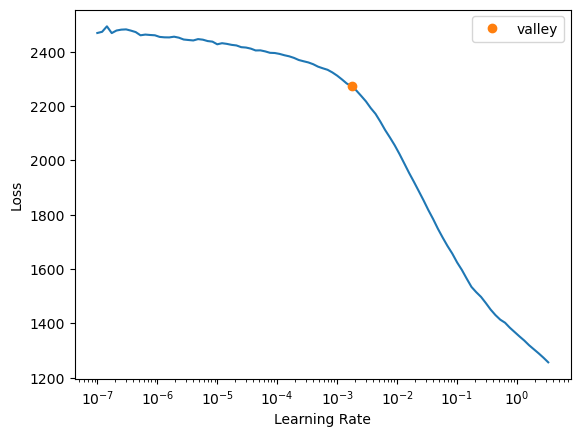

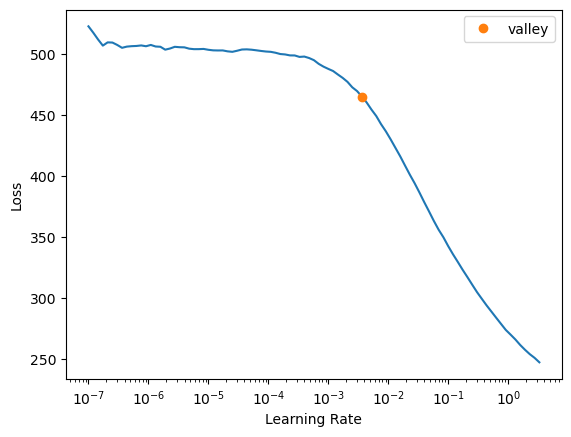

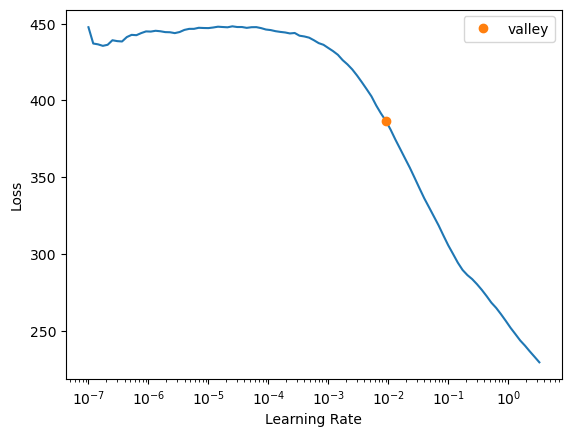

In [178]:
dep_var = "pv_measurement"
cat_names = [
    "estimated",
    "dew_or_rime:idx",
    "precip_type_5min:idx",
]
cont_names = [
    col for col in train_df.columns if col not in cat_names + [dep_var, "location"]
]

procs = [
    tabular_all.Categorify,
    tabular_all.FillMissing,
    tabular_all.Normalize,
]

all_preds = pd.DataFrame(columns=["prediction"])

importances = {"A": None, "B": None, "C": None}

for location in ("A", "B", "C"):
    tabular_all.set_seed(1111)

    temp_train = (
        train_df.copy()[train_df.location == location]
        .drop(
            columns=["location"],
            errors="ignore",
        )
        .reset_index(drop=True)
    )

    val_index = (
        temp_train[temp_train.estimated == 1].sample(frac=0.4, random_state=1111).index
    )

    splits = tabular_all.IndexSplitter(val_index)(temp_train)

    to = tabular_all.TabularPandas(
        temp_train,
        procs=procs,
        cat_names=cat_names,
        cont_names=[
            col
            for col in train_df.columns
            if col not in cat_names + [dep_var, "location"]
        ],
        y_names=dep_var,
        splits=splits,
        y_block=tabular_all.RegressionBlock(),
    )

    dls = to.dataloaders(bs=128, seed=42)

    config = tabular_all.tabular_config(ps=0.2)

    learn = tabular_all.tabular_learner(
        dls,
        metrics=[fastai.losses.L1LossFlat()],
        loss_func=fastai.losses.L1LossFlat(),
        # config=config,
        # layers=[512, 256, 128, 62],
        y_range=(0, train_df[train_df.location == location].pv_measurement.max()),
    )

    lr = learn.lr_find()

    learn.fit_one_cycle(20, lr)


    tst_dl = learn.dls.test_dl(
        test_df[test_df.location == location]
        .copy()
        .drop(
            columns=["location"],
            errors="ignore",
        )
    )
    preds, _ = learn.get_preds(dl=tst_dl)

    all_preds = pd.concat(
        [all_preds, pd.DataFrame(preds.numpy(), columns=["prediction"])]
    )

In [179]:
test_result["neural_net"] = all_preds

# 3 – Postprocessing

In [181]:
test_result["autogluon_new"]

pv_measurement location
89957       -0.589823        A
89960       -0.283832        A
89963       -1.928154        A
89966       64.499908        A
89969      385.536621        A
...               ...      ...
92104       75.168472        C
92107       45.174786        C
92110       18.374838        C
92113        5.933227        C
92116        5.305576        C

[2160 rows x 2 columns]

In [182]:
# Manually chosen weights
weights = [0.40, 0.20, 0.40]

# Weights calculated using LP Meta Model
weights_2 = np.array([-0.11873, 0.19438, 0.21091, 0.71344])

autogluon_test = np.array(test_result["autogluon"]["pv_measurement"].to_list().copy())
autogluon_test[:720] = (
    autogluon_test[:720] * 0.8
    + 0.2 * test_result["autogluon_new"]["pv_measurement"].to_numpy()[:720]
)
autogluon_test[1440:] = (
    autogluon_test[1440:] * 0.9
    + 0.1 * test_result["autogluon_new"]["pv_measurement"].to_numpy()[1440:]
)

# taking average of the Location Specific Catboost Models by taking np.avg of all

average_location_catboost = np.mean(
    [
        test_result["location_catboost"].to_numpy(),
        test_result["location_catboost_2"].to_numpy(),
        test_result["location_catboost_3"].to_numpy(),
        test_result["location_catboost_4"].to_numpy(),
        test_result["location_catboost_5"].to_numpy(),
        test_result["location_catboost_6"].to_numpy(),
        test_result["location_catboost_7"].to_numpy(),
        test_result["location_catboost_8"].to_numpy(),
        test_result["location_catboost_9"].to_numpy(),
        test_result["location_catboost_10"].to_numpy(),
    ],
    axis=0,
)

ensamble = (
    +weights[0] * autogluon_test
    + weights[1] * test_result["neural_net"]["prediction"].to_numpy()
    + weights[2]
    * np.dot(
        weights_2,
        (
            test_result["general_lightgbm"].to_numpy(),
            test_result["encoded_catboost"].to_numpy(),
            test_result["transform_catboost"].to_numpy(),
            average_location_catboost,
        ),
    )
)

ensamble[720:] = (
    ensamble[720:] * 0.7
    + 0.3 * test_result["autogluon_new"]["pv_measurement"].to_numpy()[720:]
)

ensamble = np.array(np.maximum(ensamble, 0))

print("Weights:", weights)
print("Sum:", np.sum(weights))
print("Sum:", np.sum(weights_2))

Weights: [0.4, 0.2, 0.4]
Sum: 1.0
Sum: 1.0


In [183]:
constraint = (
    data_standard[data_standard["data_type"].isin(["observed"]) & data_standard["month"].isin([5, 6, 7])]
    .groupby(["month", "hour", "location"])["pv_measurement"]
    .max()
    .reset_index()
)

In [197]:
kaggle_data = (
    data_standard[data_standard.data_type.isin(["test"])]
    .sort_values(["location", "date_forecast"])
    .copy()
).reset_index(drop=True)

kaggle_data["pv_measurement"] = ensamble
kaggle_data["pv_measurement_post"] = pd.merge(
    kaggle_data, constraint, on=["hour", "month", "location"], how="left"
)["pv_measurement_y"].values
kaggle_data["pv_measurement_post"] = np.where(
    kaggle_data["pv_measurement_post"] < kaggle_data["pv_measurement"],
    kaggle_data["pv_measurement_post"],
    kaggle_data["pv_measurement"],
)
kaggle_data["pv_measurement_post"] = np.where(
    kaggle_data["pv_measurement_post"] < 4, 0, kaggle_data["pv_measurement_post"]
)

In [198]:
np.sum(kaggle_data["pv_measurement"] - kaggle_data["pv_measurement_post"]) / 2160

0.32253332033062376

# 4 – Submission

In [188]:
output_df = pd.DataFrame(
    kaggle_data["pv_measurement_post"].values, columns=["prediction"]
)
output_df = output_df.reset_index(names="id")
output_df.to_csv(
    "../data/results/" + str(datetime.datetime.now()) + "-ensamble.csv", index=False
)